# Machine learning engineer  - тестовое задание, 2024
[Ссылка на ТЗ](https://incredible-tulip-5c3.notion.site/Machine-learning-engineer-2024-e4c30223002a4eebb33d2cdeb8f81fb1)

Выполнила: **Наумова Екатерина**


Каналы связи со мной: 
<div id="badges" style="display: flex; gap: 10px;">
  <a href="https://t.me/Naumova_E">
    <img src="https://img.shields.io/badge/Telegram-229ED9?style=for-the-badge&logo=telegram&logoColor=white" alt="Telegram Badge"/>
  <a href="https://www.linkedin.com/in/naumova-kotya/">
    <img src="https://img.shields.io/badge/LinkedIn-blue?style=for-the-badge&logo=linkedin&logoColor=white" alt="LinkedIn Badge"/>
  <a href="https://github.com/naumovakotya">
    <img src="https://img.shields.io/badge/GitHub-black?style=for-the-badge&logo=GitHub&logoColor=white" alt="GitGub Badge"/>
  <a href="mailto:naumova.ea.1@gmail.com">
    <img src="https://img.shields.io/badge/Gmail-red?style=for-the-badge&logo=gmail&logoColor=white" alt="Gmail Badge"/>
  <a href="https://www.facebook.com/profile.php?id=100022394204077">
    <img src="https://img.shields.io/badge/Facebook-blue?style=for-the-badge&logo=Facebook&logoColor=white" alt="Facebook Badge"/>
</div>

## Формулировка задачи

Доступны данные о количестве обращений за медицинской помощью по 50 000 застрахованным ДМС за 2022 год. Требуется на основании характеристик застрахованных и истории их обращений за 2022 год предсказать количество визитов за 2023 год. 

Доступны 2 выборки: 

- `train` - выборка для обучения и валидации, 50 тыс. застрахованных с проставленными значениями `target`.
- `holdout` - выборка для финального замера качества модели. В этой выборке 10 000 застрахованных, истинные значения `target` скрыты.

Для оценки качества модели будет применяться метрика `MSE`.

**План проекта:**
1) Загрузка необходимых библиотек и данных
2) Анализ данных, который включает в себя предобработку данных (работа с пропусками, дубликатами, обработка текстовых данных), EDA
3) Обучение нескольких моделей и выбор лучшей
4) Тестирование лучшей модели
5) Выводы

**Характеристики проекта:**
- `Random state` = 42
- `Test size` = 0.2
- Метрика - `MSE` 
- Вывод графика значимости призков у лучшей модели

**Ожидаемые результаты:**
1. Рабочий ноутбук или файл .py, содержащий:
    - Код предобработки данных
    - Код обучения модели
    - Код тестирования модели
2. Файл .csv с предсказаниями на выборке `holdout` с указанием ид застрахованного и предсказанием модели
3. Список использованных признаков с указанием их значимости
4. Комментарии по ходу выполнения задачи

## Загрузка данных

In [1]:
# Загрузка необходимых библиотек
import warnings
import re
import os

import pandas as pd
import numpy as np
import phik
import scipy.stats as ss

import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from collections import Counter
from scipy import stats

import optuna
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

In [2]:
# настройки
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)
optuna.logging.disable_default_handler()

In [3]:
# константы
RANDOM_STATE = 42
TEST_SIZE = 0.2
N_TRIALS = 50
SCORE = 'neg_mean_squared_error'

<a id="functions-downloading"></a>
### Functions

In [4]:
# функция для открытия данных
def open_data_excel(name_file):
    try:
        df = pd.read_excel(name_file)
        return df
    except: 
        print('Что-то пошло не так. Проверьте местонахождение либо имя файла с данными')

In [5]:
# функция для просмотра данных        
def data_review(data):
    """
    Function for viewing data:
    - first 5 strings;
    - general information about the data (info);
    - the number of duplicated in the data;
    - statistics by numeric columns (describe).
    """
    print('ПЕРВЫЕ 5 СТРОЧЕК С ДАННЫМИ:')
    display(data.head())
    print(f'\nОБЩАЯ ИНФОРМАЦИЯ О ДАННЫХ:\n')
    data.info()
    print(f'\n\nКОЛИЧЕСТВО ПРОПУСКОВ В ДАННЫХ:\n\n{data.isna().sum()}\n')
    print(f'\nКОЛИЧЕСТВО ДУБЛИКАТОВ В ДАННЫХ - {data.duplicated().sum()}\n')
    print('\nСТАТИСТИКА ПО ЧИСЛОВЫМ СТОЛБЦАМ:')
    display(data.describe())

### Загрузка и первичное знакомство с данными

In [6]:
# загрузка и первичное знакомство с данными (train и valid)
df = open_data_excel('ML_train.xlsx')

data_review(df)

ПЕРВЫЕ 5 СТРОЧЕК С ДАННЫМИ:


,Insured_PIN,Insured_Network,Nationality,Gender,Relation,DoB,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23,number_of_visits_23
0,1006786,Network-4,Group 2,Male,Self,1974-04-28,NaN,0,365,0,0,365,0
1,1008861,Network-2,Saudi,Female,Child,2017-07-27,J20.9;J02,0,365,1,2,365,4
2,1019055,Network-5,Group 2,Male,Self,1979-02-20,J03.9,0,365,1,4,365,5
3,1019438,Network-1,Saudi,Male,Self,1985-05-09,E56.9;J02;J00,1,365,3,18,365,11
4,1027311,Network-3,Group 3,Male,Self,1962-01-01,NaN,0,365,0,0,365,0



ОБЩАЯ ИНФОРМАЦИЯ О ДАННЫХ:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Insured_PIN            50000 non-null  int64         
 1   Insured_Network        50000 non-null  object        
 2   Nationality            50000 non-null  object        
 3   Gender                 50000 non-null  object        
 4   Relation               50000 non-null  object        
 5   DoB                    49999 non-null  datetime64[ns]
 6   Diagnoses              41226 non-null  object        
 7   HasChronicDisease      50000 non-null  int64         
 8   Exposition_22          50000 non-null  int64         
 9   number_of_visits_22    50000 non-null  int64         
 10  number_of_services_22  50000 non-null  int64         
 11  Exposition_23          50000 non-null  int64         
 12  number_of_visits_23    50000 no

,Insured_PIN,DoB,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23,number_of_visits_23
count,5.000000e+04,49999,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.105307e+06,1990-02-22 19:50:30.036600704,0.337940,358.898960,5.740320,22.477420,355.588420,5.898860
min,7.491000e+03,1920-03-21 00:00:00,0.000000,50.000000,0.000000,0.000000,50.000000,0.000000
25%,1.394020e+06,1971-03-23 00:00:00,0.000000,365.000000,1.000000,3.000000,365.000000,1.000000
50%,1.456638e+06,1991-11-13 00:00:00,0.000000,365.000000,4.000000,13.000000,365.000000,4.000000
75%,1.560591e+06,2011-04-17 00:00:00,1.000000,365.000000,8.000000,31.000000,365.000000,8.000000
max,9.100533e+07,2022-11-12 00:00:00,1.000000,365.000000,151.000000,962.000000,365.000000,202.000000
std,1.443978e+07,NaN,0.473013,35.562003,6.592556,29.714146,43.779065,6.856904


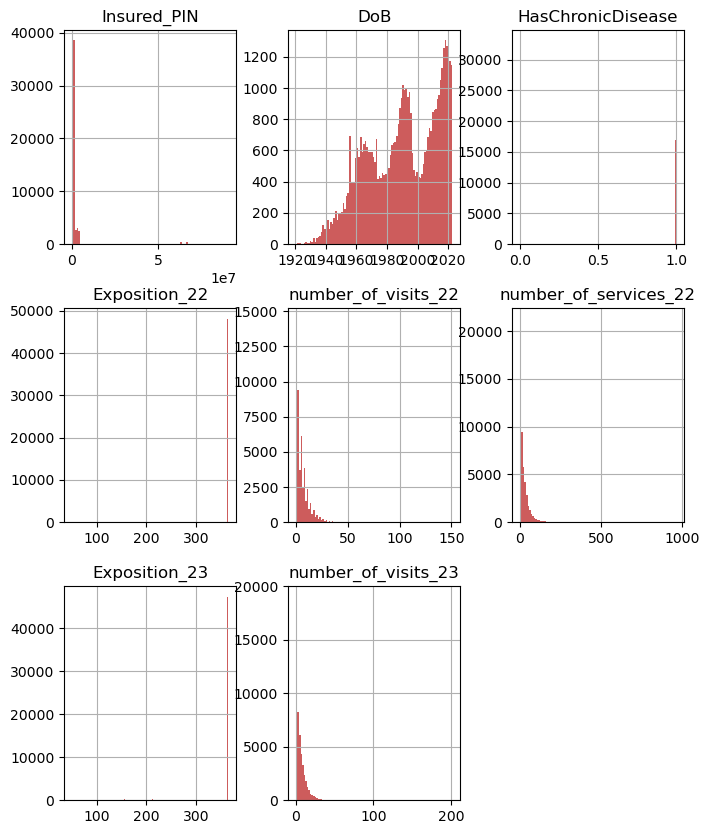

In [7]:
df.hist(figsize=(8, 10), bins = 100, color='indianred');

**Описание данных:**

- `Insured_PIN` - уникальный ид застрахованного лица
- `Insured_Network` - Идентификатор сети клиник доступной для застрахованного. *Network - 1* - клиники с наивысшим уровнем сервиса, *Network - 8* - клиники с самым базовым уровнем сервиса.
- `Nationality` - национальность застрахованного.
- `Gender` - пол застрахованного
- `Relation` - в качестве кого застраховано данное лицо. *self* - работник организации, которая оформляет страховку, *child* - ребенок застрахованного и т.д.
- `DoB` - дата рождения застрахованного
- `Diagnoses` - все диагнозы застрахованного за 2022 год
- `HasChronicDisease` - флаг хронического пациента
- `Exposition_22` - количество дней в 2022 году в которые у данного застрахованного действовал полис медицинского страхования. Значение 365 говорит о том, что застрахованный мог обращаться за медицинской помощью весь 2022 год
- `number_of_visits_22` - количество дней в 2022 году в которые застрахованный посещал клинику для получения медицинской помощи
- `number_of_services_22` - количество оказанных медицинских услуг в 2022 году (консультации, анализы, лекарства и т.д.)
- `Exposition_23` - количество дней в 2023 году в которые у данного застрахованного действовал полис медицинского страхования. Значение 365 говорит о том, что застрахованный мог обращаться за медицинской помощью весь 2023 год
- **`Target` -** `number_of_visits_23` - количество дней в 2023 году в которые застрахованный посещал клинику для получения медицинской помощи. **Этот показатель требуется предсказать.**

In [8]:
test = open_data_excel('ML_holdout.xlsx')

data_review(test)

ПЕРВЫЕ 5 СТРОЧЕК С ДАННЫМИ:


,Insured_PIN,Insured_Network,Nationality,Gender,Relation,DoB,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23
0,1516424,Network-2,Saudi,Female,Child,2012-09-06,A09,0,365,1,3,365
1,22210474,Network-1,Saudi,Female,Child,1995-10-26,T78.4;R50.9;Z01.8;R05,0,365,4,22,365
2,1518945,Network-2,Saudi,Female,Spouse,1962-11-28,D64.9;J06;H04.1;M13.9,0,365,5,11,365
3,1344077,Network-2,Saudi,Male,Child,2003-07-09,J06.9;J06.8;J02;G44.0;M25.5;R51;E55;L03,1,365,9,30,365
4,1354276,Network-2,Saudi,Female,Spouse,1995-07-22,UNKRC;N64;A09,0,365,3,10,365



ОБЩАЯ ИНФОРМАЦИЯ О ДАННЫХ:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Insured_PIN            10000 non-null  int64         
 1   Insured_Network        10000 non-null  object        
 2   Nationality            10000 non-null  object        
 3   Gender                 10000 non-null  object        
 4   Relation               10000 non-null  object        
 5   DoB                    10000 non-null  datetime64[ns]
 6   Diagnoses              8274 non-null   object        
 7   HasChronicDisease      10000 non-null  int64         
 8   Exposition_22          10000 non-null  int64         
 9   number_of_visits_22    10000 non-null  int64         
 10  number_of_services_22  10000 non-null  int64         
 11  Exposition_23          10000 non-null  int64         
dtypes: datetime64[ns](1), int64(6), 

,Insured_PIN,DoB,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23
count,1.000000e+04,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5.321900e+06,1990-02-05 12:24:02.880000128,0.338000,359.426100,5.823600,22.991300,355.038600
min,6.366500e+04,1922-02-13 00:00:00,0.000000,50.000000,0.000000,0.000000,50.000000
25%,1.394638e+06,1970-09-01 18:00:00,0.000000,365.000000,1.000000,3.000000,365.000000
50%,1.457448e+06,1991-11-09 12:00:00,0.000000,365.000000,4.000000,13.000000,365.000000
75%,1.622645e+06,2011-02-19 06:00:00,1.000000,365.000000,8.000000,31.000000,365.000000
max,9.105157e+07,2022-11-12 00:00:00,1.000000,365.000000,113.000000,495.000000,365.000000
std,1.487940e+07,NaN,0.473052,33.756826,6.789425,30.820412,45.307745


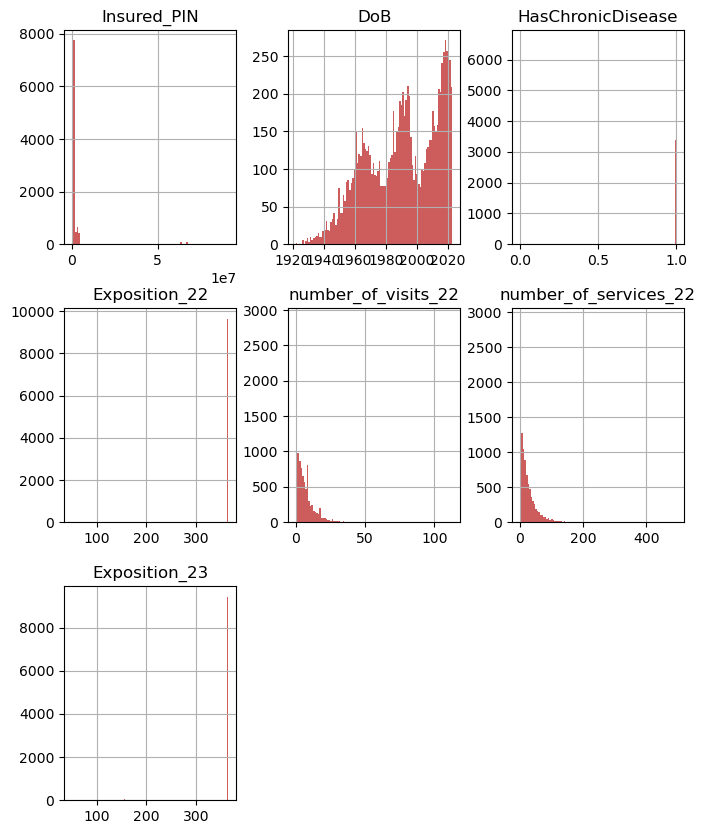

In [9]:
test.hist(figsize=(8, 10), bins = 100, color='indianred');

### Выводы:
1. Данные загружены успешно, среди которых 12 столбцов с информацией застрахованного лица и 1 с данными, которые предстоит предсказать.

2. Полных дубликатов не обнаружено, однако есть пропуски в данных, с которыми предстоит разобраться на следующем этапе обработки данных. Радует, что они не в целевом признаке, поэтому большую часть данных оставим без удаления.

3. Также на следующем этапе планируется просмотр данных на анамальные значения, корреляционные связи признаков с `target`, создание новых признаков и другие необходимые подготовительные действия перед обучением данных.

4. На следующем этапе стоит посмотреть распределение каждого из признаков в отдельности.

## Исследовательский анализ данных

<a id="functions-research"></a>
### Functions

In [10]:
# Функция для изменения названий столбцов
def modify_column_name(col_name):
    # Проверяем, есть ли в названии символ "_"
    if '_' in col_name:
        # Если есть, просто приводим название к нижнему регистру
        new_name = col_name.lower()
    else:
        # Если нет, вставляем знак "_" перед каждой заглавной буквой, кроме первой, и делаем все буквы маленькими
        new_name = col_name[0].lower() + ''.join(['_' + char.lower() if char.isupper() else char for char in col_name[1:]])
    return new_name

In [11]:
# Функция для вычисления возраста в месяцах
def calculate_age_in_months(birth_date, reference_date='2023-01-01'):
    reference_date = pd.to_datetime(reference_date)
    age_years = reference_date.year - birth_date.year
    age_months = reference_date.month - birth_date.month
    total_months = age_years * 12 + age_months
    if reference_date.day < birth_date.day:
        total_months -= 1
    return total_months

# Функция для подсчёта количества диагнозов
def count_diagnoses(diagnoses):
    if diagnoses == 'no_diagnoses':
        return 0
    else:
        return len(diagnoses.split(';'))

# Функция для создания новых признаков
def create_new_features(df):
    # Данные из столбца'do_b'
    df['do_b'] = pd.to_datetime(df['do_b'])
    df['birth_year'] = df['do_b'].dt.year
    df['birth_month'] = df['do_b'].dt.month
    df['age_in_months'] = df['do_b'].apply(lambda x: calculate_age_in_months(x))
    
    # Количество диагнозов у пациента
    df['number_of_diagnoses'] = df['diagnoses'].apply(count_diagnoses)
    return df

In [12]:
# Функция для проверки процентного соотношения уникальных значений 
def unique_percentage(col):
    return col.nunique()/col.count()*100

In [13]:
# Функция для построения графика с уникальными значениями и  их распределением в датасете
def plot_distribution(df, column, color='indianred'):
    # Группировка данных по указанному столбцу и подсчет количества значений в каждой группе
    value_counts = df[column].value_counts()

    # Построение графика
    plt.figure(figsize=(10, 6))
    value_counts.plot(kind='bar', color=color)
    plt.title(f'Распределение по количеству значений в столбце "{column}"')
    plt.xlabel(column)
    plt.ylabel('Количество значений')
    plt.xticks(rotation=45)
    plt.show()

In [14]:
# Функция для построения графика распределения дат рождения по годам
def plot_birth_date_distribution(df, color='indianred'):
    bins = max(df['birth_year']) - min(df['birth_year']) + 1
    
    plt.figure(figsize=(10, 6))
    df['birth_year'].hist(bins=bins, color=color, edgecolor='black')
    plt.title(f'Распределение дат рождения по годам')
    plt.xlabel('Год рождения')
    plt.ylabel('Количество застрахованных')
    plt.xticks(rotation=45)
    plt.grid(False)
    plt.show()

In [15]:
# Функция для построение графика Количества диагнозов у клиента
def plot_numb_diagnosis (df):
    plt.figure(figsize=(10, 6))
    plt.hist(df['number_of_diagnoses'], bins=range(0, df['number_of_diagnoses'].max() + 2), color='indianred', edgecolor='indianred')
    plt.xlabel('Количество диагнозов')
    plt.ylabel('Количество пациентов')
    plt.title('Распределение количества диагнозов')
    plt.show()

# и функция для построения boxplot 
def boxplot_num_diagnosis(df, color='indianred'):
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df['number_of_diagnoses'], color=color)
    plt.xlabel('Количество диагнозов')
    plt.title('Распределение количества диагнозов (Boxplot)')
    plt.show()


# Функция для проверки дубликатов диагнозов
def check_duplicate_diagnoses(df):
    # Функция для обнаружения дубликатов в строке
    def has_duplicates(diagnoses):
        diagnoses_list = diagnoses.split(';')
        return len(diagnoses_list) != len(set(diagnoses_list)) 
    
    # Применение функции к столбцу диагнозов
    df['has_duplicates'] = df['diagnoses'].apply(has_duplicates)
    
    # Фильтрация строк, где есть дубликаты
    duplicates = df[df['has_duplicates']]
    
    return duplicates

# Функция для построения столбчатой диаграммы для топ-N диагнозов
def top_n_diagnosis(df, top_n=10):
    # Объединение всех диагнозов в один список
    all_diagnoses = []
    for diagnoses in df['diagnoses']:
        if diagnoses != 'no_diagnoses':
            all_diagnoses.extend(diagnoses.split(';'))
            
    # Подсчет частоты каждого диагноза
    diagnosis_counts = Counter(all_diagnoses)
    
    # Преобразование в DataFrame для удобства визуализации
    diagnosis_df = pd.DataFrame(diagnosis_counts.items(), columns=['diagnosis', 'count'])
    print(f'Количество уникальных значений среди диагнозов: {diagnosis_df.count()[0]}')
    
    # Сортировка по частоте в порядке убывания
    diagnosis_df = diagnosis_df.sort_values(by='count', ascending=False)
    
    # Выбор топ-N диагнозов
    top_diagnoses_df = diagnosis_df.head(top_n)

    # Построение столбчатой диаграммы для топ-N диагнозов
    plt.figure(figsize=(12, 8))
    plt.bar(top_diagnoses_df['diagnosis'], top_diagnoses_df['count'], color='indianred')
    plt.xlabel('Диагноз')
    plt.ylabel('Частота')
    plt.title(f'Топ-{top_n} самых частых диагнозов')
    plt.xticks(rotation=45)
    plt.show()

In [16]:
# Функция для визуализации числовых данных (распределение числовых данных и Boxplot)
def plot_numerical_distribution_and_boxplot(df, column_name):
    """
    Строит график распределения и Boxplot для числовых столбцов
    """
    plt.figure(figsize=(12, 6))

    # Гистограмма распределения
    sns.histplot(df[column_name], bins=30, kde=True, color='indianred')

    plt.xlabel(column_name)
    plt.ylabel('Частота')
    plt.title(f'Распределение значений для столбца {column_name}')
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=df[column_name], color='lightcoral')
    plt.xlabel(column_name)
    plt.title(f'Boxplot для столбца {column_name}')
    plt.show()

In [17]:
# Функция для cоздания списка названий категориальных признаков
def get_categorical_features(df):
    """ 
    Извлекает названия всех столбцов с типом данных 'category' или 'object',
    а также включает 'has_chronic_disease' и 'birth_month', но удаляет 'diagnoses', если он существует.
    """
    categorical_features = df.select_dtypes(include=['category', 'object']).columns.tolist()
    categorical_features.append('has_chronic_disease')
    categorical_features.append('birth_month')
    if 'diagnoses' in categorical_features:
        categorical_features.remove('diagnoses')  # Удаляем 'diagnoses', если столбец есть
    return categorical_features

# Функция для cоздания списка названий числовых признаков
def get_numerical_features(df, categorical_features):
    # Извлечение всех числовых признаков согласно типу данных
    numeric_features = df.select_dtypes(include=['int32','int64', 'float64']).columns
    exclude_columns = ['insured_pin', 'has_duplicates']

    # Исключаем ненужные столбцы и категориальные признаки
    numeric_features = [col for col in numeric_features if col not in exclude_columns and col not in categorical_features]

    return numeric_features

In [18]:
# КОРРЕЛЯЦИОННЫЙ АНАЛИЗ

# Функция, которая стороит графики распределения number_of_visits_23 в категориальных признаках
def plot_categorical_analysis(df, target, feature):
    """
    Строит графики распределения целевого признака в заданном категориальном признаке.

    Parameters:
    - df: pandas DataFrame
    - target: строка, название целевого столбца
    - feature: строка, название категориального столбца
    """
    plt.figure(figsize=(18, 6))
    
    # Boxplot
    plt.subplot(1, 3, 1)
    sns.boxplot(x=df[feature], y=df[target])
    plt.title(f'Boxplot: {target} vs {feature}')
    plt.xticks(rotation=45)
    
    # Violin Plot
    plt.subplot(1, 3, 2)
    sns.violinplot(x=df[feature], y=df[target])
    plt.title(f'Violin Plot: {target} vs {feature}')
    plt.xticks(rotation=45)
    
    # Bar Plot with Confidence Intervals
    plt.subplot(1, 3, 3)
    means = df.groupby(feature)[target].mean()
    conf = df.groupby(feature)[target].apply(lambda x: stats.sem(x) * stats.t.ppf((1 + 0.95) / 2., len(x) - 1))
    sns.barplot(x=means.index, y=means.values, yerr=conf.values, capsize=0.2)
    plt.title(f'Bar Plot: {target} vs {feature} (с доверительными интервалами)')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# Функция для построения корреляционной матрицы между числовыми признаками
def plot_correlation_matrix(df, numeric_features):
    """
    Строит тепловую карту корреляций между числовыми признаками.
    """
    corr = df[numeric_features].corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Корреляционная матрица')
    plt.show()

### Пропуски
Однако, прежде чем перейдём к обработке пропусков, приведёв все столбцы к единному стилю и переименуем целевой признак `number_of_visits_23` в `target`.

In [19]:
# Приведём все названия столбцов к единному стилю в обоих датасетах
df.columns = [modify_column_name(col) for col in df.columns]
test.columns = [modify_column_name(col) for col in test.columns]

# Изменим название с number_of_visits_23 на target
df = df.rename(columns={'number_of_visits_23': 'target'})

In [20]:
print('Тренировочный датасет:')
pd.DataFrame(round(df.isna().mean()*100)).style.background_gradient('coolwarm')

Тренировочный датасет:


,0
insured_pin,0.000000
insured_network,0.000000
nationality,0.000000
gender,0.000000
relation,0.000000
do_b,0.000000
diagnoses,18.000000
has_chronic_disease,0.000000
exposition_22,0.000000
number_of_visits_22,0.000000


In [21]:
print('Тестовый датасет:')
pd.DataFrame(round(test.isna().mean()*100)).style.background_gradient('coolwarm')

Тестовый датасет:


,0
insured_pin,0.000000
insured_network,0.000000
nationality,0.000000
gender,0.000000
relation,0.000000
do_b,0.000000
diagnoses,17.000000
has_chronic_disease,0.000000
exposition_22,0.000000
number_of_visits_22,0.000000


В предварительном анализе было обнаружено, что имеются пропуска в столбцах `DoB` и `Diagnoses`. В случае даты рождения клиента был обнаружен всего один пропуск, поэтому просто удалим его, а в случае Диагнозов за 2022 год пропусков больше, но можно предположить, что клиент просто мало или не обращался вовсе к услугам медицинской помощи.

И данную гипотезу подтверждает результат ниже, где мы можем увидеть, что пациенты, у которых стоят диагнозы намного чаще обращались за медицинской помощью.

In [22]:
# Заполнение пропусков значением 'no_diagnoses'
df['diagnoses'] = df['diagnoses'].fillna('no_diagnoses')
test['diagnoses'] = test['diagnoses'].fillna('no_diagnoses')

grouped_diagnoses = df.groupby(df['diagnoses'] == 'no_diagnoses')['target'].mean()

# Переименование категорий группировки
grouped_diagnoses.index = grouped_diagnoses.index.map({True: 'Диагноз отсутствует', False: 'Диагноз был поставлен'})

# Вывод результата
print("Средние значения по столбцу 'target':")
print(grouped_diagnoses)

Средние значения по столбцу 'target':
diagnoses
Диагноз был поставлен    6.849391
Диагноз отсутствует      1.432642
Name: target, dtype: float64


In [23]:
# Удаление пропуска
df = df.dropna(subset=['do_b'])

In [24]:
# Проверка, что отсутсвуют пропущенные значения
print(f'Тренировочный датасет:\n{df.isna().sum()}')

Тренировочный датасет:
insured_pin              0
insured_network          0
nationality              0
gender                   0
relation                 0
do_b                     0
diagnoses                0
has_chronic_disease      0
exposition_22            0
number_of_visits_22      0
number_of_services_22    0
exposition_23            0
target                   0
dtype: int64


In [25]:
print(f'Тестовый датасет:\n{test.isna().sum()}')

Тестовый датасет:
insured_pin              0
insured_network          0
nationality              0
gender                   0
relation                 0
do_b                     0
diagnoses                0
has_chronic_disease      0
exposition_22            0
number_of_visits_22      0
number_of_services_22    0
exposition_23            0
dtype: int64


### Аномальные значения
Рассмотрим каждый из столбцов данных подробнее, чтобы в случае чего обработать аномальные значения, возможные опечатки в тестовых данных, частичные дубликаты (полных дубликатов нет, уже проверили) и создание новых признаков.


Начнём с создания новых признаков, которые могут помочь при обучении модели. Функция, где указаны все создаваемые признаки находится в разделе [Functions](#functions-research). И ниже кратко расскажу о создании новых признаков.

- Из даты рождения извлекаем год и месяц рождения, а также возраст в месяцах на 1 января 2023 года. Возраст в месяцах, так как среди застрахованных есть маленькие дети.

- Из столбца с перечислением диагнозов, вытаскиваем количество диагнозов.


In [26]:
df = create_new_features(df)
df.head()

,insured_pin,insured_network,nationality,gender,relation,do_b,diagnoses,has_chronic_disease,exposition_22,number_of_visits_22,number_of_services_22,exposition_23,target,birth_year,birth_month,age_in_months,number_of_diagnoses
0,1006786,Network-4,Group 2,Male,Self,1974-04-28,no_diagnoses,0,365,0,0,365,0,1974,4,584,0
1,1008861,Network-2,Saudi,Female,Child,2017-07-27,J20.9;J02,0,365,1,2,365,4,2017,7,65,2
2,1019055,Network-5,Group 2,Male,Self,1979-02-20,J03.9,0,365,1,4,365,5,1979,2,526,1
3,1019438,Network-1,Saudi,Male,Self,1985-05-09,E56.9;J02;J00,1,365,3,18,365,11,1985,5,451,3
4,1027311,Network-3,Group 3,Male,Self,1962-01-01,no_diagnoses,0,365,0,0,365,0,1962,1,732,0


In [27]:
test = create_new_features(test)
test.head()

,insured_pin,insured_network,nationality,gender,relation,do_b,diagnoses,has_chronic_disease,exposition_22,number_of_visits_22,number_of_services_22,exposition_23,birth_year,birth_month,age_in_months,number_of_diagnoses
0,1516424,Network-2,Saudi,Female,Child,2012-09-06,A09,0,365,1,3,365,2012,9,123,1
1,22210474,Network-1,Saudi,Female,Child,1995-10-26,T78.4;R50.9;Z01.8;R05,0,365,4,22,365,1995,10,326,4
2,1518945,Network-2,Saudi,Female,Spouse,1962-11-28,D64.9;J06;H04.1;M13.9,0,365,5,11,365,1962,11,721,4
3,1344077,Network-2,Saudi,Male,Child,2003-07-09,J06.9;J06.8;J02;G44.0;M25.5;R51;E55;L03,1,365,9,30,365,2003,7,233,8
4,1354276,Network-2,Saudi,Female,Spouse,1995-07-22,UNKRC;N64;A09,0,365,3,10,365,1995,7,329,3


#### insured_pin
Данный столбец означает уникальный ид застрахованного лица.

In [28]:
# Проверим все ли уникальные значения в столбце с уникальным id застрахованного лица
print('Процент уникальных значений в столбце "insured_pin":')
print(f'- тренировочный: {unique_percentage(df["insured_pin"]):.2f}%')
print(f'- тестовый: {unique_percentage(test["insured_pin"]):.2f}%')

Процент уникальных значений в столбце "insured_pin":
- тренировочный: 100.00%
- тестовый: 100.00%


Все значения в столбце `insured_pin` оказались уникальными, а это значит, что каждая строка соответствует одному пациенту и нет повторений. Другими словами, что нет ошибок, когда ID одинаковое, а значения у пациентов разные (при условии, что отсутствуют полные дубликаты), и все ID являются действительно уникальными.

Однако, данный столбец при обучение модели использоваться не будет, так как не является информативным.

#### insured_network


Данный столбец означает идентификатор сети клиник доступной для застрахованного. `Network - 1` - клиники с наивысшим уровнем сервиса, `Network - 8` - клиники с самым базовым уровнем сервиса. 

Если рассмотреть получившиеся графики ниже, то распределение по клиникам нельзя назвать равномерным, однако плюс, что на тренировочные и тестовые данные между собой достаточно похожи. 

Получается, что в первую очередь клиенты идут в клики с высоким уровнем сервиса (`Network - 2`) и наоборот, клиники с базовым уровнем сервиса (6, 7 и 8 уровни) пользуются наименьшим интересом.

Тренировочный датасет


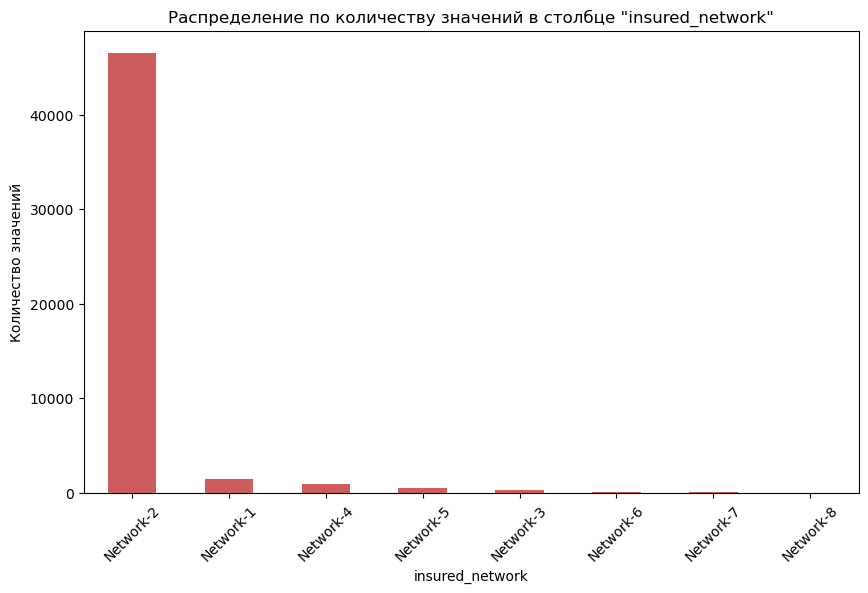


Тестовый датасет


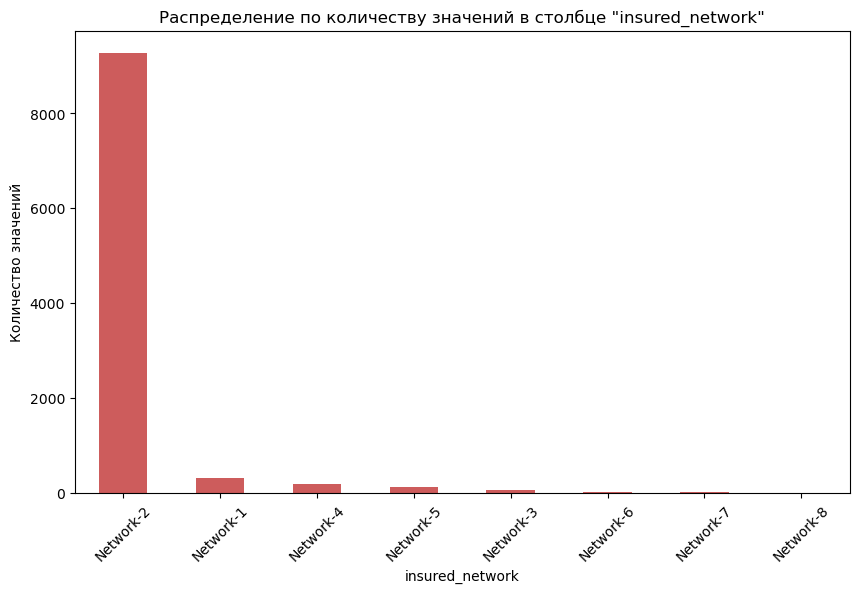

In [29]:
# Посмотрим уникальные значения и распределние их количества в наших датасетах
print('Тренировочный датасет')
plot_distribution(df, 'insured_network')

print('\nТестовый датасет')
plot_distribution(test, 'insured_network')

#### nationality
Данный столбец содержит информацию о национальности застрахованного.

По результатам ниже, можем увидеть, что большая часть застрахованных лиц относится к национальности `Saudi`, а далее `Group 2`, `Group 3`, `Group 4`, `Others`, `Group 1`. Подобное распределение в тестовых данных.

Тренировочный датасет


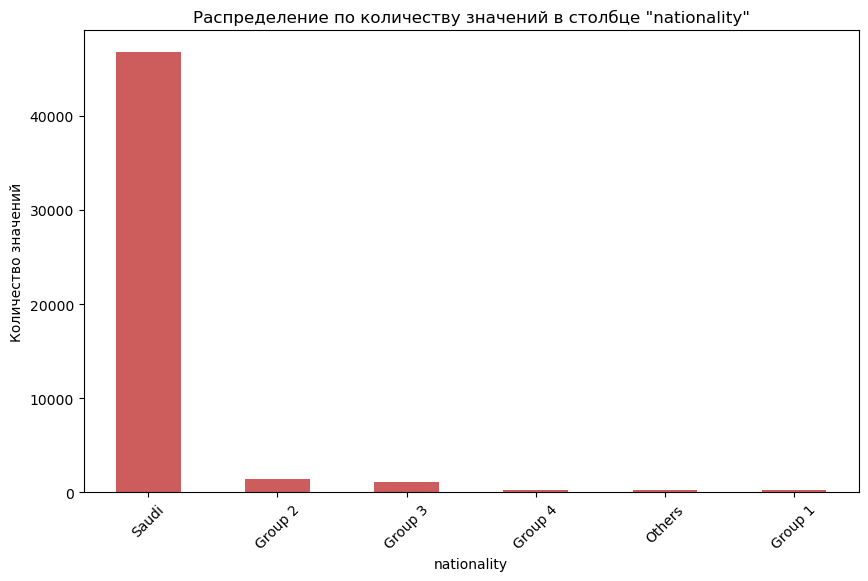


Тестовый датасет


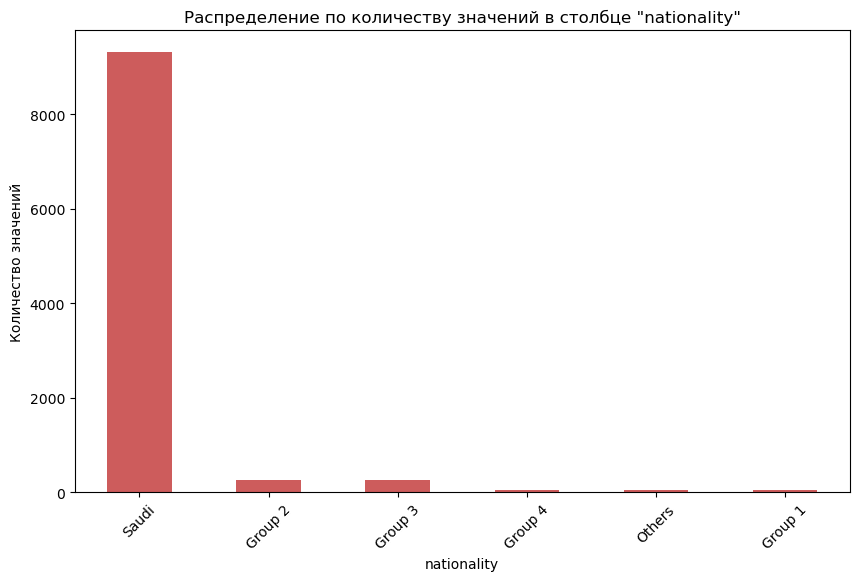

In [30]:
# Посмотрим уникальные значения и распределение их количества в наших датасетах
print('Тренировочный датасет')
plot_distribution(df, 'nationality')

print('\nТестовый датасет')
plot_distribution(test, 'nationality')

#### gender
Данный столбец содержит информацию о поле застрахованного. В обеих выборках количество застрахованных мужчин чуть больше количества женщин, однако разница незначительная.

Тренировочный датасет


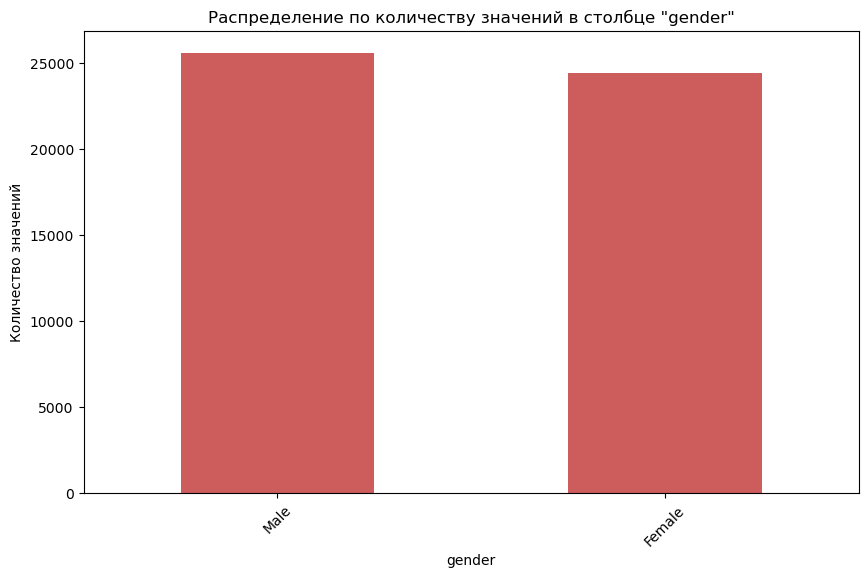


Тестовый датасет


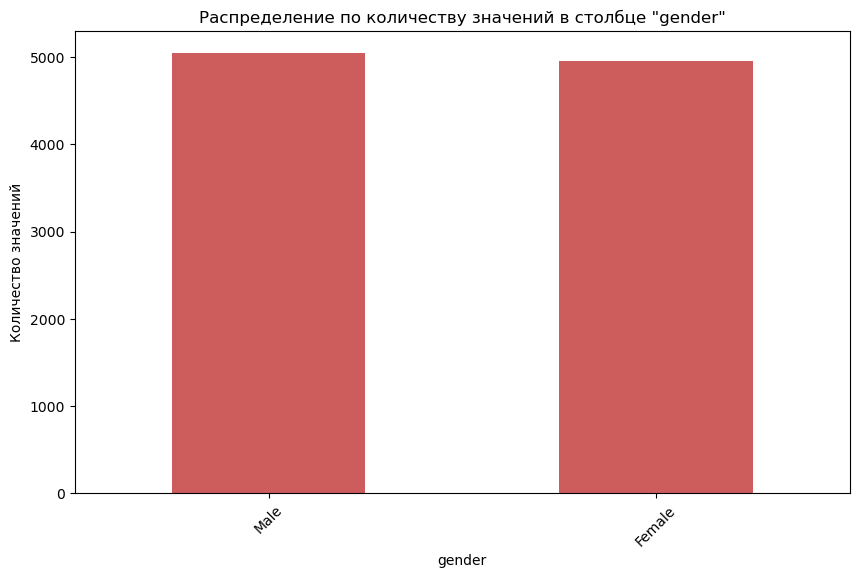

In [31]:
# Посмотрим уникальные значения и распределение их количества в наших датасетах
print('Тренировочный датасет')
plot_distribution(df, 'gender')

print('\nТестовый датасет')
plot_distribution(test, 'gender')

#### relation
Данный столбец `relation` содержит информацию в качестве кого застраховано данное лицо. `self` - работник организации, которая оформляет страховку, `child` - ребенок застрахованного и т.д..

Снова радует, что распределение данных в тренировочной и тестовой выборках очень похоже. Если говорить про сам признак, то среди застрахованных больше всего работников организации, на втором месте их дети, далее супруги и совсем маленькое значение застрахованных относится к родителям работников и группе `Другие`.

Тренировочный датасет


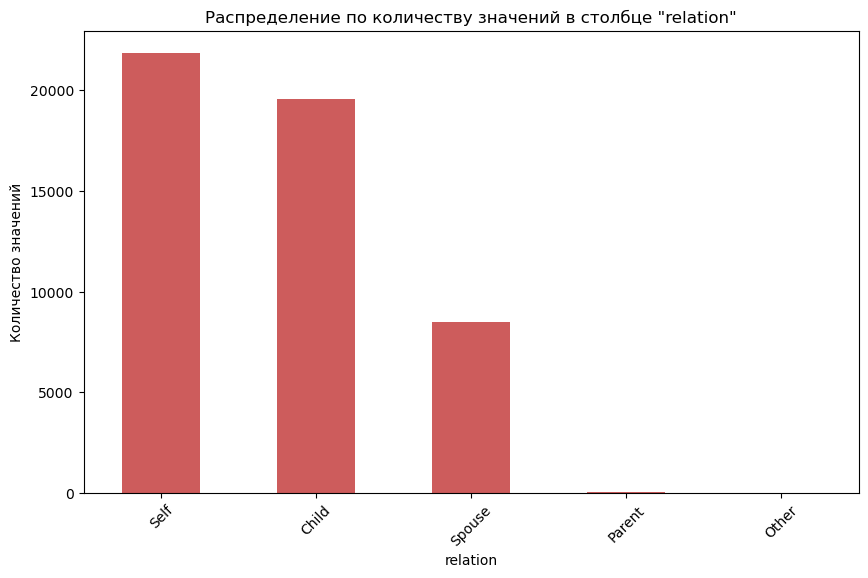


Тестовый датасет


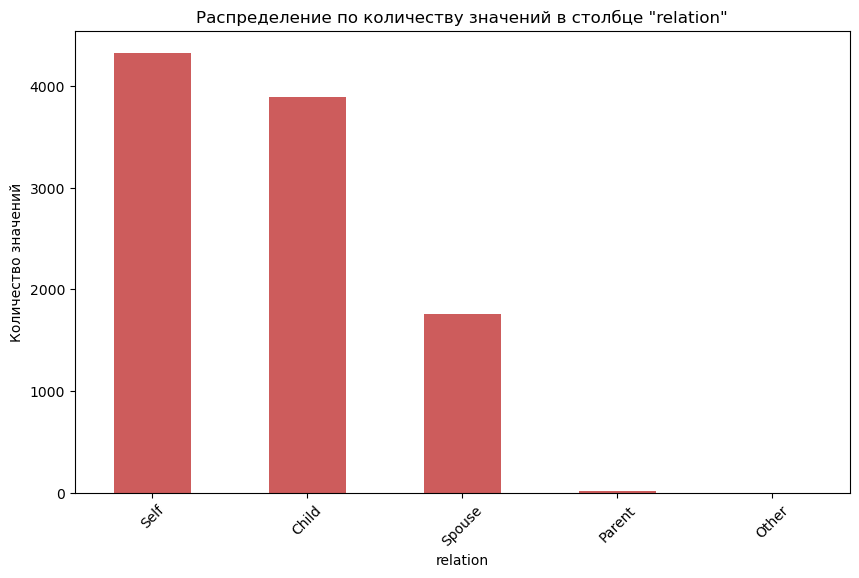

In [32]:
# Посмотрим уникальные значения и распределение их количества в наших датасетах
print('Тренировочный датасет')
plot_distribution(df, 'relation')

print('\nТестовый датасет')
plot_distribution(test, 'relation')

#### do_b 
Данный столбец содержит информацию о дате рождения застрахованного. У нас снова похожее распределение признаков в тренировочном и тестовом датасете. 

Стоит обратить внимание, что у обоих графиков есть примерно три пика:
- в районе 60-70-ых годов
- в районе 90-95-ого года
- в районе 2015 года (самый высокий).

Последний скорее всего относится к детям, в силу возраста.

Тренировочный датасет


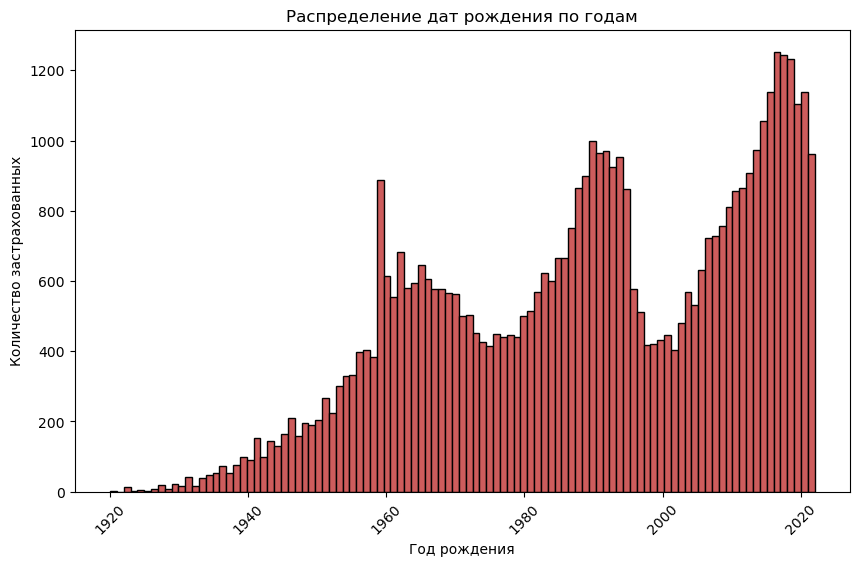


Тестовый датасет


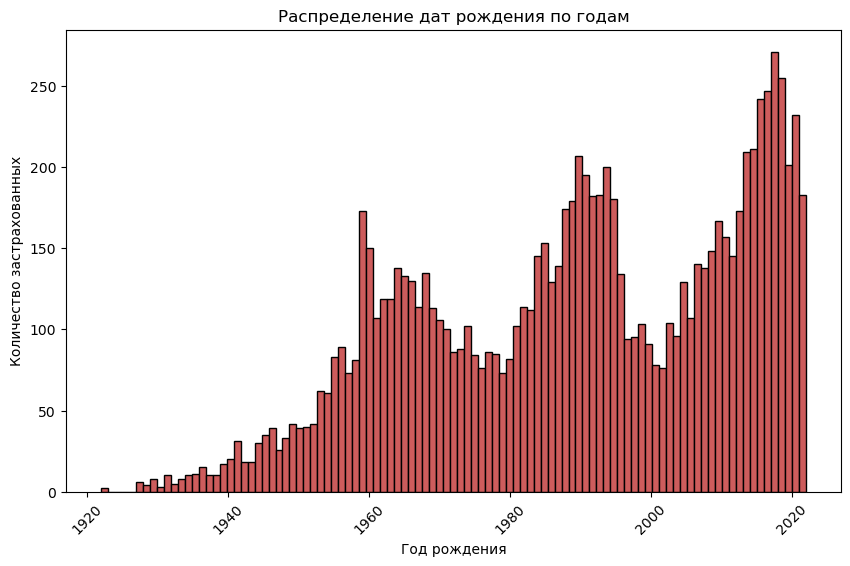

In [33]:
# Построения графика распределения дат рождения по годам
print('Тренировочный датасет')
plot_birth_date_distribution(df)

print('\nТестовый датасет')
plot_birth_date_distribution(test)

#### diagnoses
Данный столбец содержит информацию о всех диагнозах застрахованного за 2022 год. Самый интересный столбец, как мне кажется, поэтому постараемся рассмотреть его с разных сторон.

Раннее был создан признак как количество диагнозов у застрахованных, поэтому для начала построим гистограмму по количеству диагнозов.

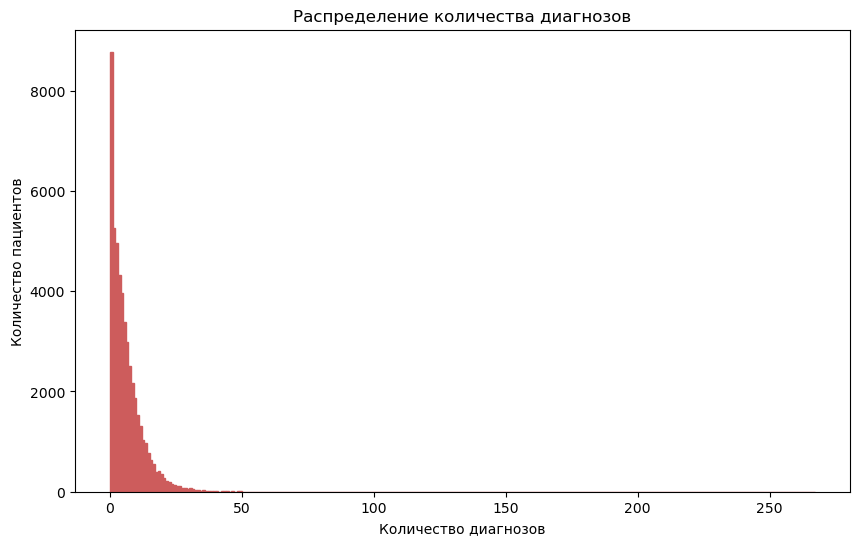

In [34]:
# Построение гистограммы распределения количества диагнозов
plot_numb_diagnosis(df)

Только гистограммы оказалось мало, поэтому ниже построен ещё boxplot. Можно увидеть, что размах количества диагнозов от 0 до 266, при условии, что большая часть значений находится в диапозоне от 0 и примерно до 30, а далее уже выбросы.

Максимальное значение в столбце number_of_diagnoses = 266


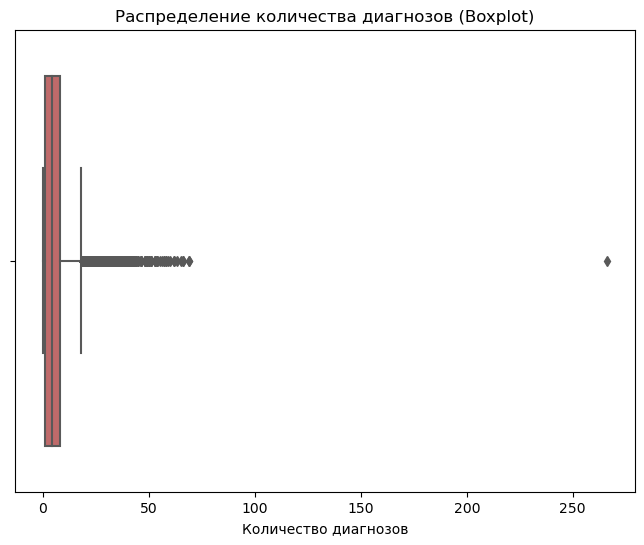

In [35]:
print(f'Максимальное значение в столбце number_of_diagnoses = {df["number_of_diagnoses"].max()}')

# Построение boxplot    
boxplot_num_diagnosis(df)

А теперь посмотрим, что у нас на тестовых данных.

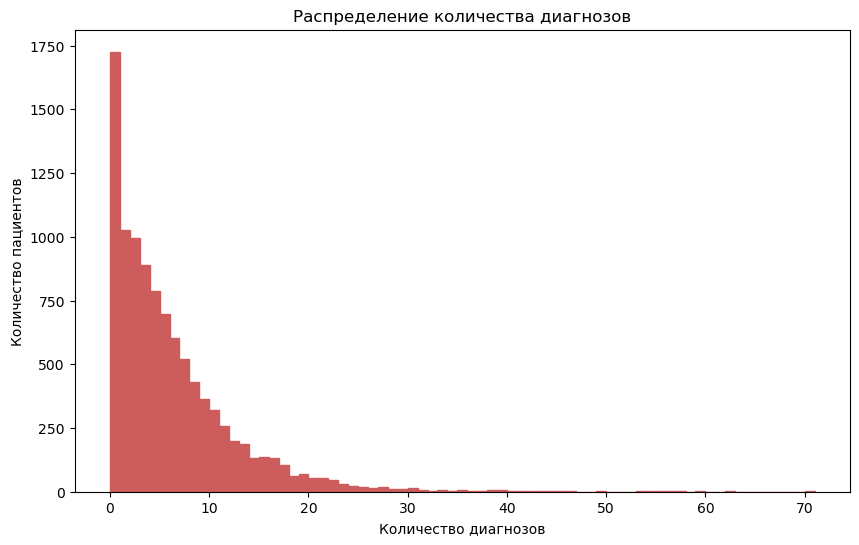

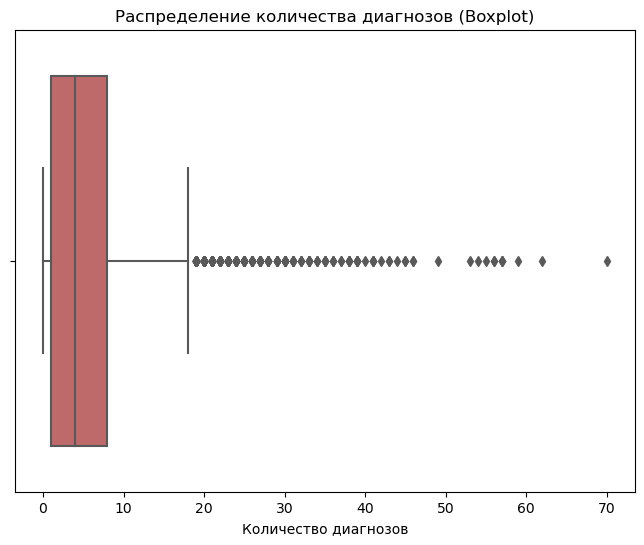

In [36]:
plot_numb_diagnosis(test)
boxplot_num_diagnosis(test)

Получается, что настолько аномальных значений нет, хотя выбросов всё равно много. Тогда удалим строку данных, где у нас у одного застрахованого 266 диагнозов за 2022 год. Однако перед этим проверим наличие дубликатов внутри списка дубликатов каждого из пользователей.

In [37]:
# Поиск строк с дубликатами диагнозов
duplicates_train = check_duplicate_diagnoses(df)
print('Тренировочный датасет')
print("Строки с дубликатами диагнозов:")
duplicates_train

Тренировочный датасет
Строки с дубликатами диагнозов:


,insured_pin,insured_network,nationality,gender,relation,do_b,diagnoses,has_chronic_disease,exposition_22,number_of_visits_22,number_of_services_22,exposition_23,target,birth_year,birth_month,age_in_months,number_of_diagnoses,has_duplicates


In [38]:
duplicates_test = check_duplicate_diagnoses(test)
print('Тестовый датасет')
print("Строки с дубликатами диагнозов:")
duplicates_test

Тестовый датасет
Строки с дубликатами диагнозов:


,insured_pin,insured_network,nationality,gender,relation,do_b,diagnoses,has_chronic_disease,exposition_22,number_of_visits_22,number_of_services_22,exposition_23,birth_year,birth_month,age_in_months,number_of_diagnoses,has_duplicates


В силу того, что вышли пустые строки, это означает, что был правда необычный клиент, у которого было записано аж 266 диагнозов, что в 8-9 раз больше, чем у других. Так как настолько анамальное значение не встречается в тестовых данных, а также что оно единственное, то данного клиента удалим из выборки.
<a id="top10-diagnoses"></a>

In [39]:
# Удаление анамального значения
df = df[df['number_of_diagnoses'] != df['number_of_diagnoses'].max()]

Тренировочный датасет
Количество уникальных значений среди диагнозов: 6216


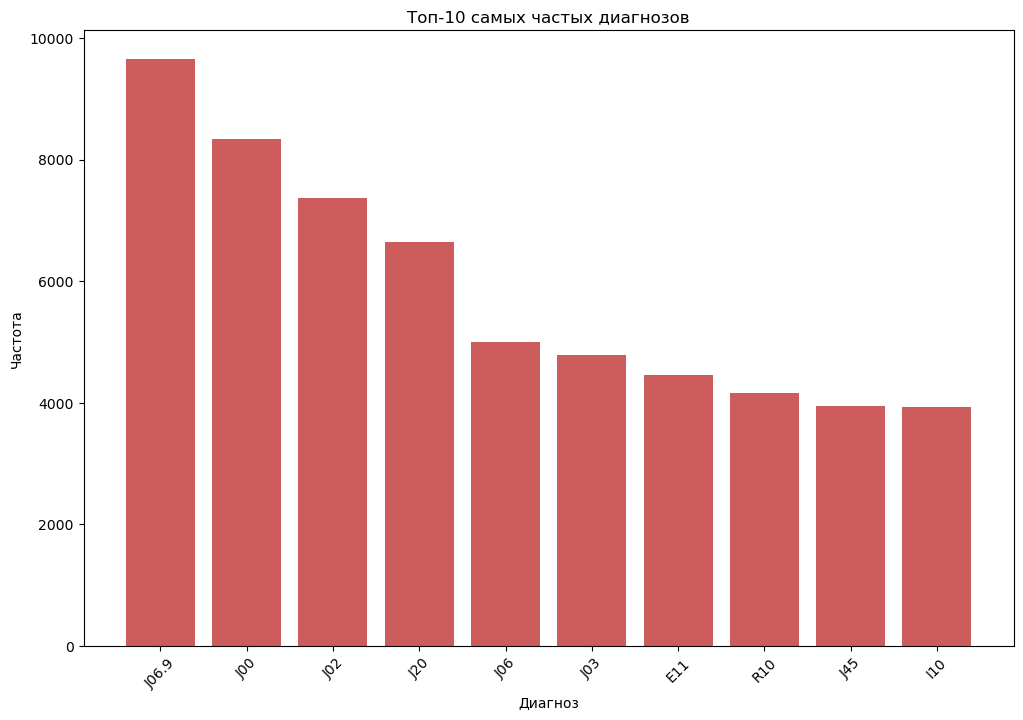


Тестовый датасет
Количество уникальных значений среди диагнозов: 3490


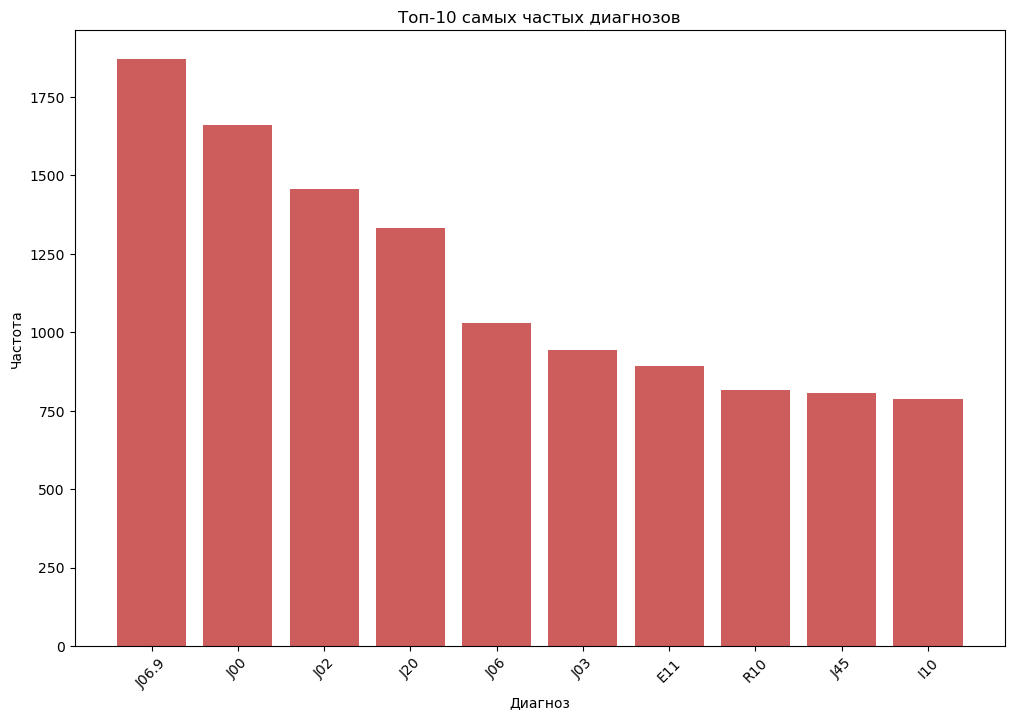

In [40]:
# Построение столбчатых диаграмм для топ-10 диагнозов 
print('Тренировочный датасет')   
top_n_diagnosis(df)

print('\nТестовый датасет')
top_n_diagnosis(test)

Радует, что снова идеальное распределение данных, что в топе 10 и в тренировочной, и в тестовой выборке оказался одинаковый список диагнозов.

Однако, такое большое уникальное количество значений не получится закодировать, чтобы передать моделям для обучения, а простые модели не работают с текстовыми значениями. Поэтому закодированы будут только столбцы из топа выше, отсутствие диагноза и все другие диагнозы, а также моделям поможет числовое значение в виде количества диагнозов, который уже добавлен в датасет.

#### has_chronic_disease
Данный столбец является флагом хронического пациента, если указано 1, и 0, если не является.

В обеих выборках можем наблюдать, что хронических пациентов меньше примерно на 50%, чем тех, у кого нет хронических заболеваний.

Тренировочный датасет


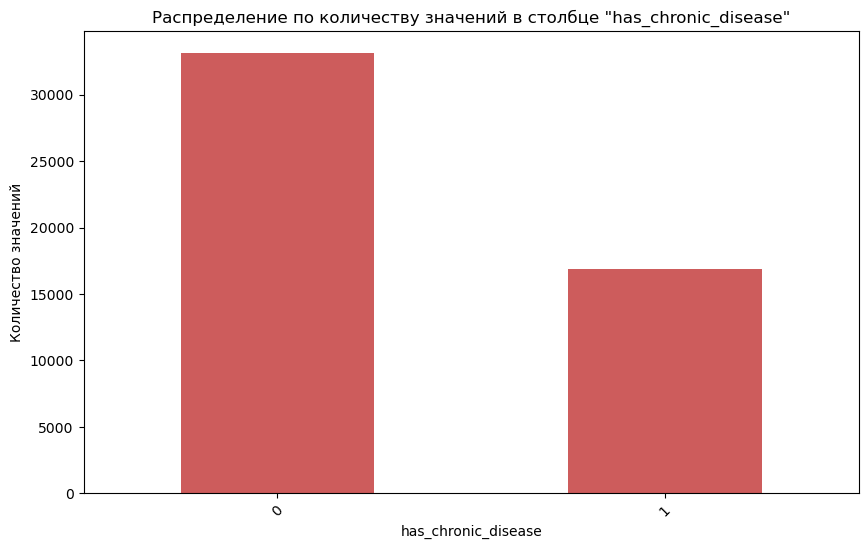


Тестовый датасет


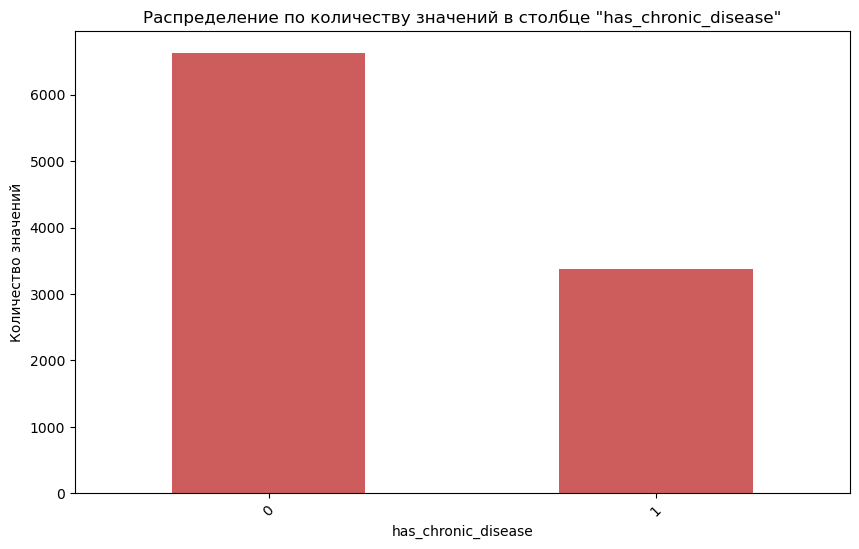

In [41]:
# Посмотрим уникальные значения и распределение их количества в наших датасетах
print('Тренировочный датасет')
plot_distribution(df, 'has_chronic_disease')

print('\nТестовый датасет')
plot_distribution(test, 'has_chronic_disease')

#### exposition_22
Данный столбец содержит информацию о количестве дней в 2022 году, в которые у данного застрахованного действовал полис медицинского страхования. Значение 365 говорит о том, что застрахованный мог обращаться за медицинской помощью весь 2022 год.

Тренировочный датасет


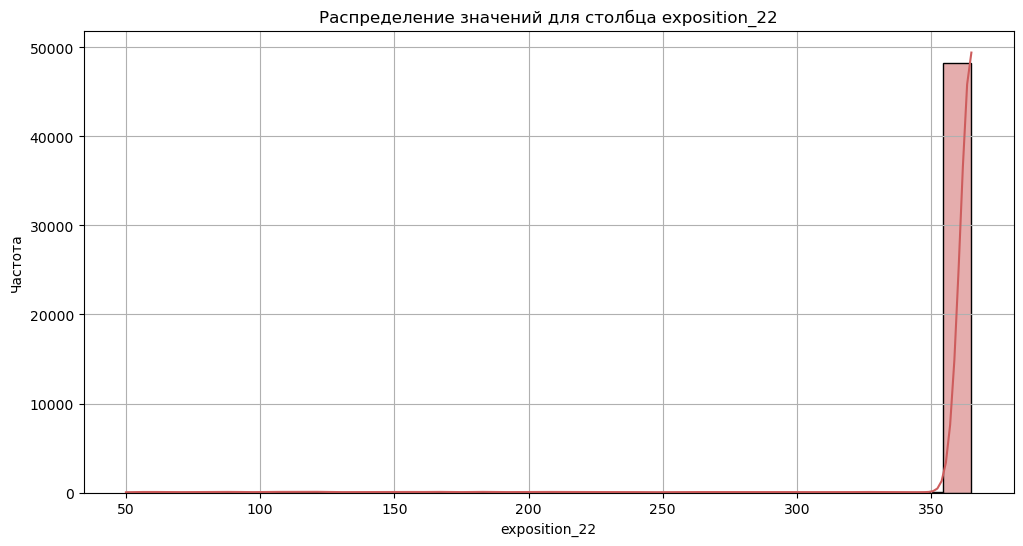

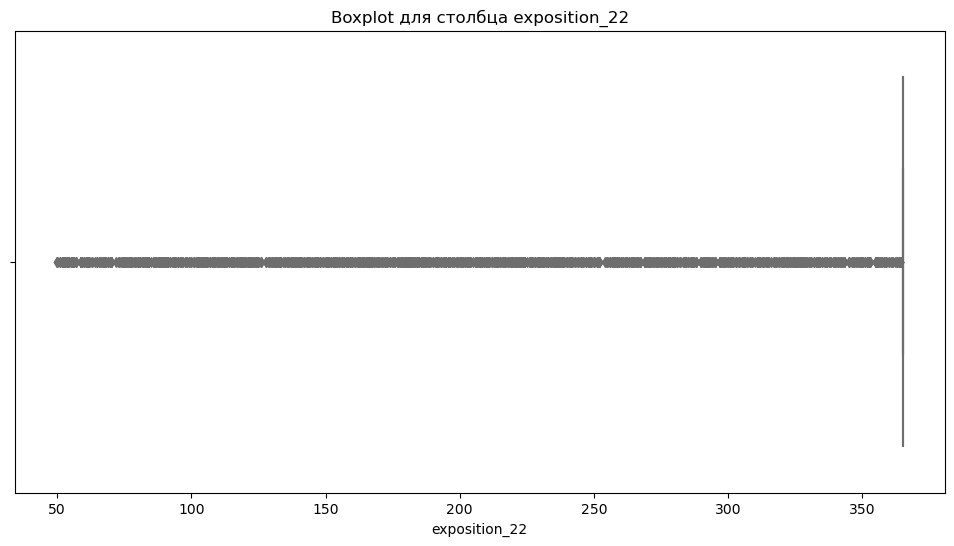

In [42]:
# Посмотрим уникальные значения и распределение их количества в наших датасетах
print('Тренировочный датасет')
plot_numerical_distribution_and_boxplot(df, 'exposition_22')

Тестовый датасет


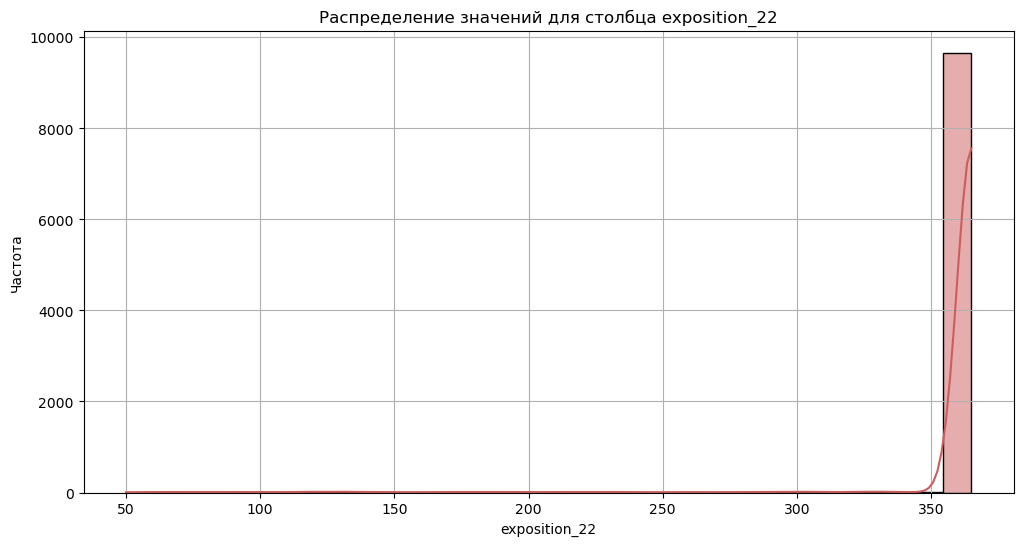

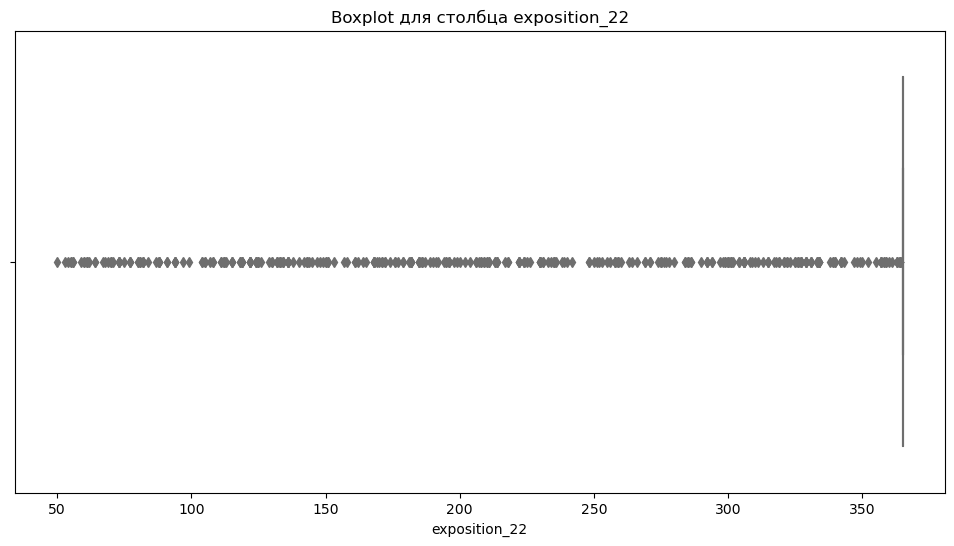

In [43]:
print('Тестовый датасет')
plot_numerical_distribution_and_boxplot(test, 'exposition_22')

Как мы видим по графикам, то наибольшее значение как раз 365 дней, то есть это пользователи, у которых весь год была активна страховка. Однако, есть также новые пользователи или пользователи, которые наоборот ушли за последний год, поэтому у них значение меньше. 

С данными выбросами ничего не будем делать, так как они также есть и в тестовой выборке, и могут присутствовать на реальных данных, а значит модель должна быть готова к таким ситуациям в том числе.

#### number_of_visits_22
Данный столбец содержит информацию о количестве дней в 2022 году, в которые застрахованный посещал клинику для получения медицинской помощи. В целом, это один из важных для нас признаков, так как нам предстоит предсказать этот же признак, но спустя год.

Тренировочный датасет


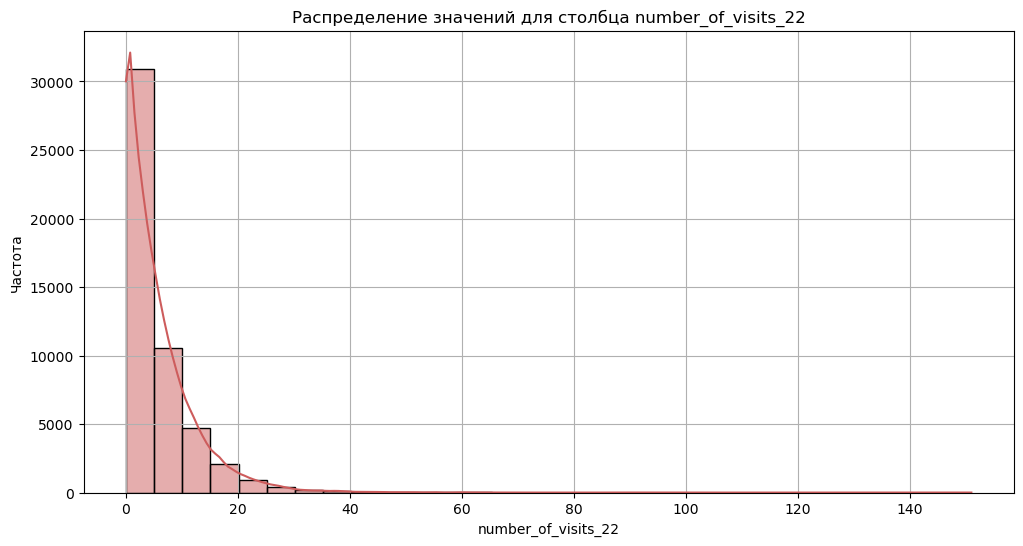

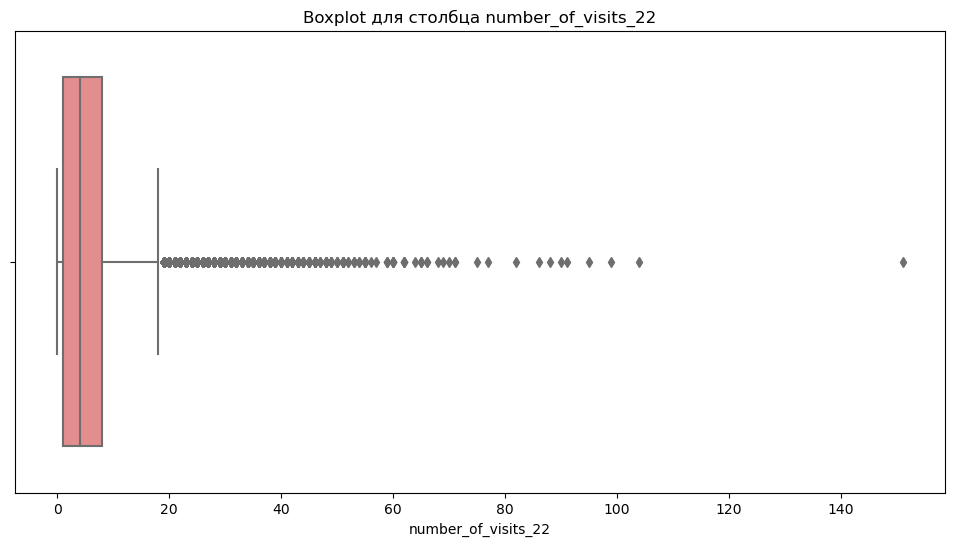

In [44]:
# Посмотрим уникальные значения и распределение их количества в наших датасетах
print('Тренировочный датасет')
plot_numerical_distribution_and_boxplot(df, 'number_of_visits_22')

Тестовый датасет


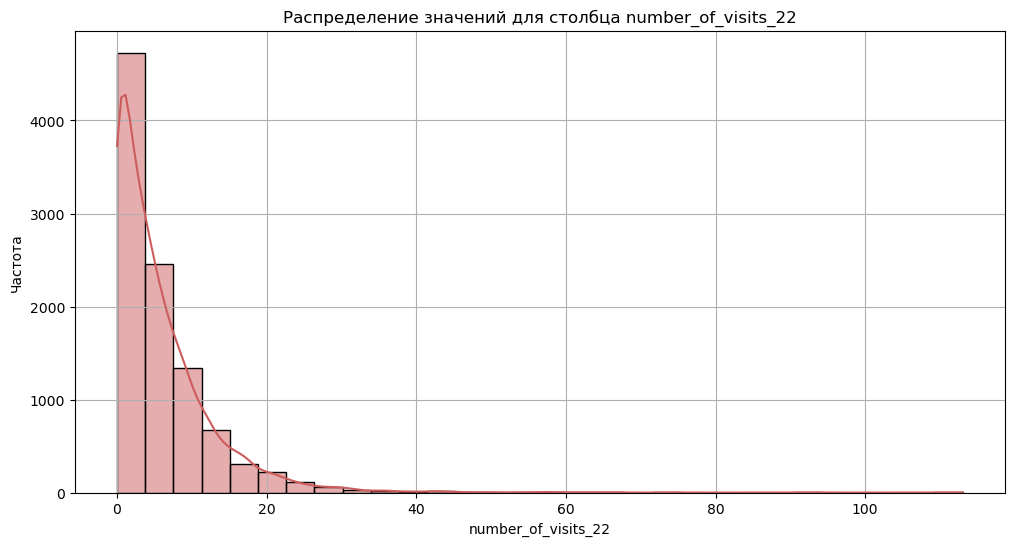

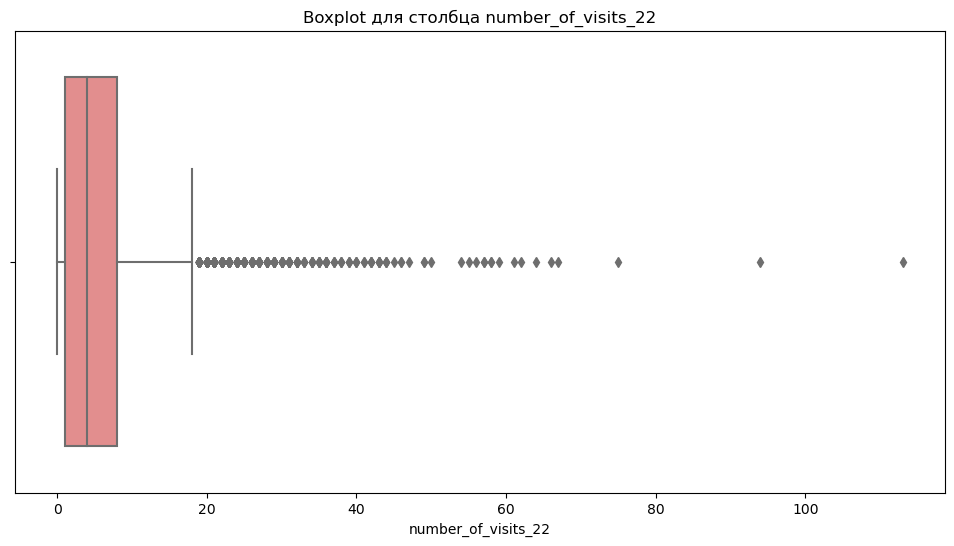

In [45]:
print('Тестовый датасет')
plot_numerical_distribution_and_boxplot(test, 'number_of_visits_22')

Большая часть данных находится в диапозоне от 0 до 20, то есть в среднем где-то в районе 7 дней каждый застрахованный посещал клинику. Однако, этот столбец не исключение в плане большого количества исключений.

В данном случае вновь никак с иключениями работать не будем, так как это отображение реальной ситуации, а значит модель должна знать о подобных случаях.

#### number_of_services_22
Данный столбец содержит информацию о количесте оказанных медицинских услуг в 2022 году (консультации, анализы, лекарства и т.д.).

Тренировочный датасет


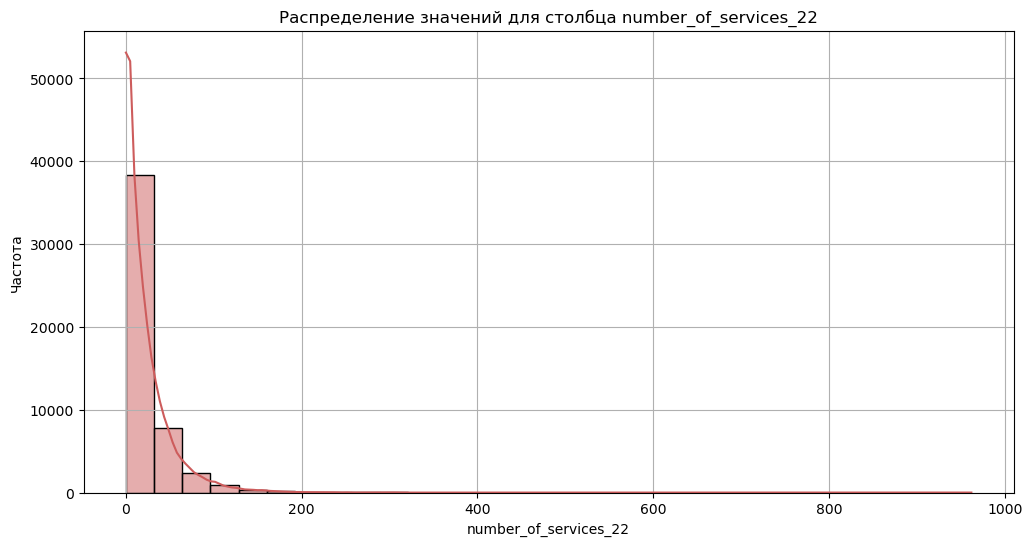

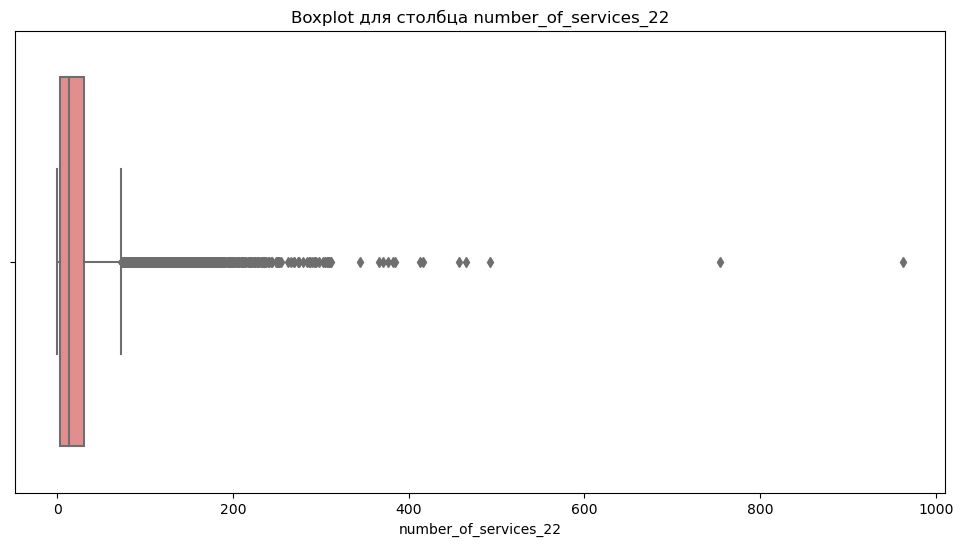

In [46]:
# Посмотрим уникальные значения и распределение их количества в наших датасетах
print('Тренировочный датасет')
plot_numerical_distribution_and_boxplot(df, 'number_of_services_22')

Тестовый датасет


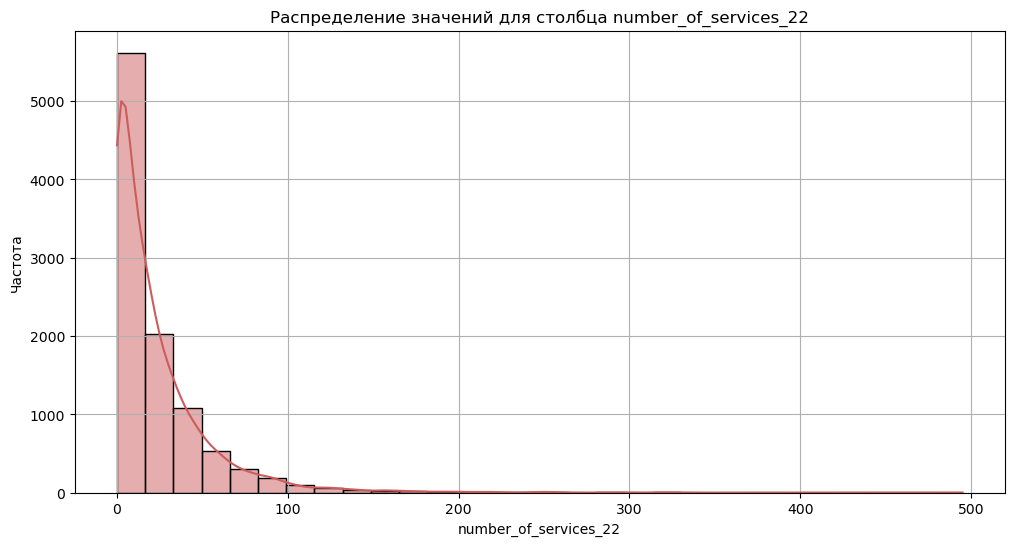

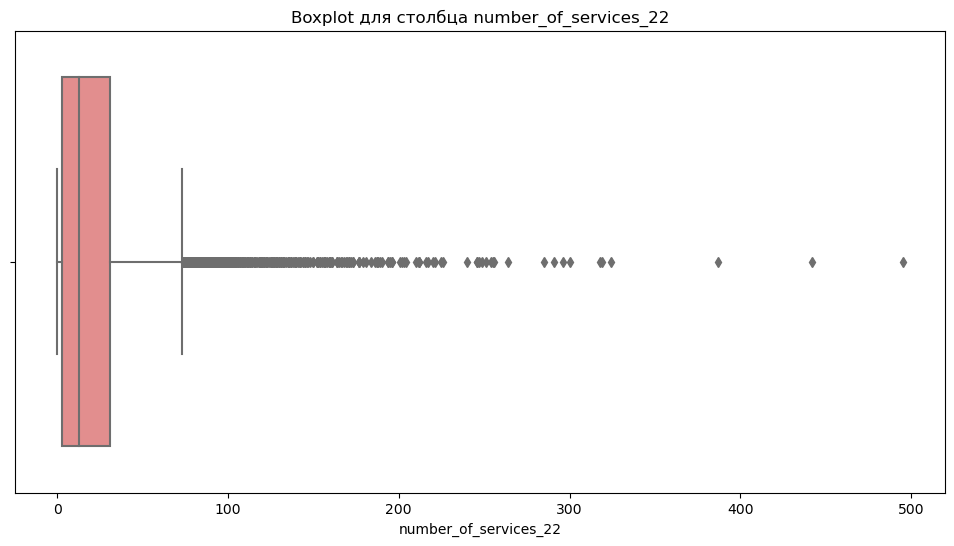

In [47]:
print('Тестовый датасет')
plot_numerical_distribution_and_boxplot(test, 'number_of_services_22')

Снова много выбросов в обеих группах, но в тестовой группе есть тоже аномальные значения, которые больше более, чем в 5 раз основную группу значений. Поэтому удалять два максимальных значения в тренировочной выборке всё-таки не будем, как минимум пока что.

#### exposition_23
Данный столбец содержит информацию о количестве дней в 2023 году в которые у данного застрахованного действовал полис медицинского страхования. Значение 365 говорит о том, что застрахованный мог обращаться за медицинской помощью весь 2023 год.

Тренировочный датасет


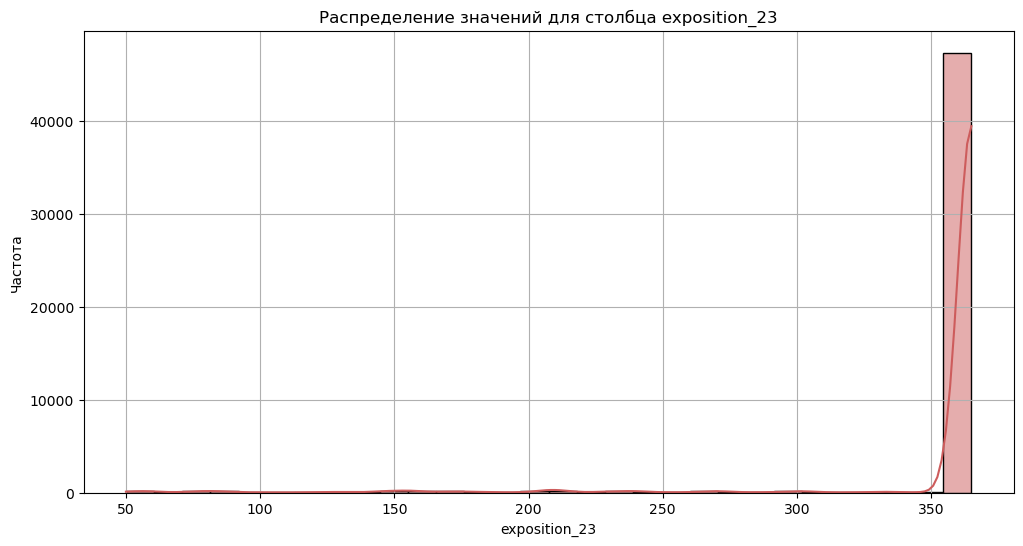

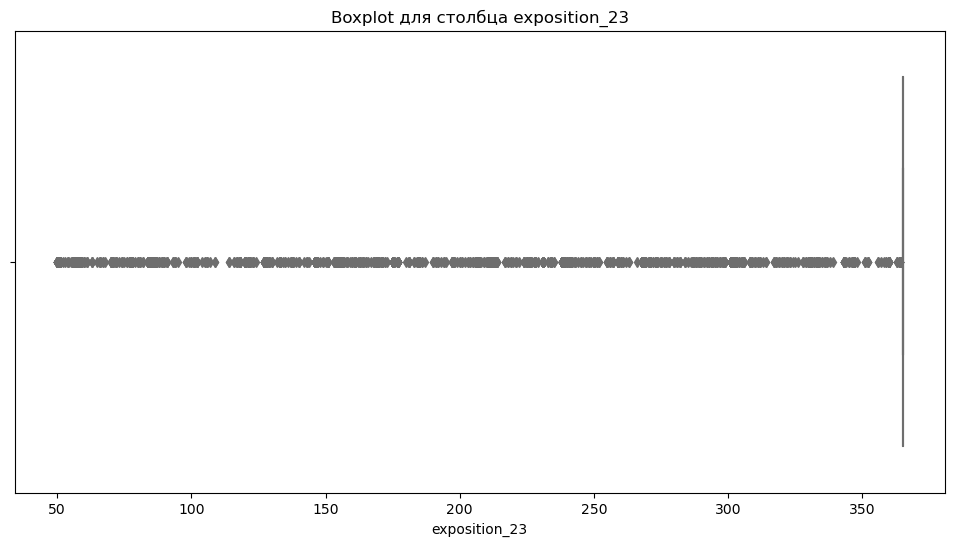

In [48]:
# Посмотрим уникальные значения и распределение их количества в наших датасетах
print('Тренировочный датасет')
plot_numerical_distribution_and_boxplot(df, 'exposition_23')

Тестовый датасет


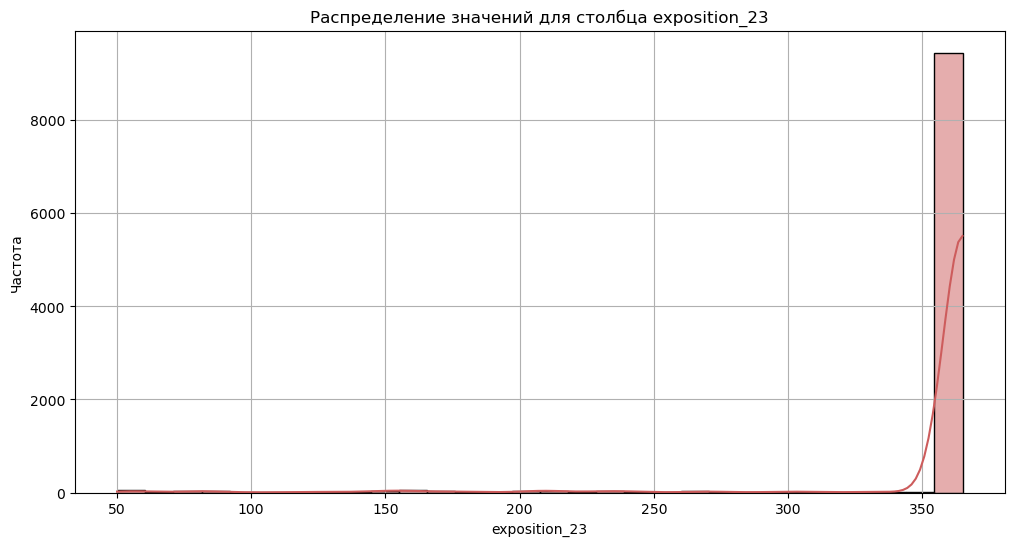

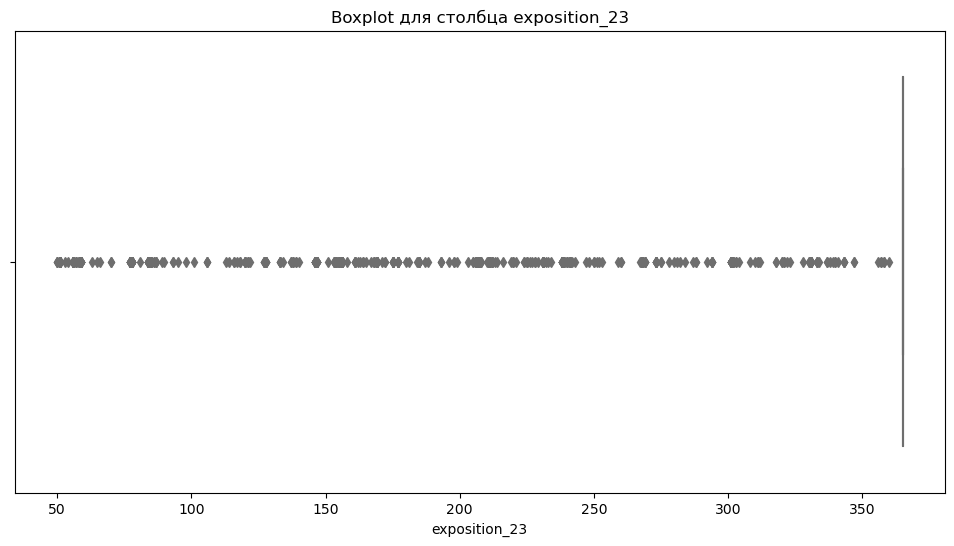

In [49]:
print('Тестовый датасет')
plot_numerical_distribution_and_boxplot(test, 'exposition_23')

Ситуация похожая с графиками у столбца `exposition_22`. Анамальных значений много, но большинство клиентов имели медицинское страхование в течение всех 365 дней.

#### number_of_visits_23 (target)
Данный столбец содержит информацию о количестве дней в 2023 году в которые застрахованный посещал клинику для получения медицинской помощи. Этот показатель требуется предсказать.

Тренировочный датасет


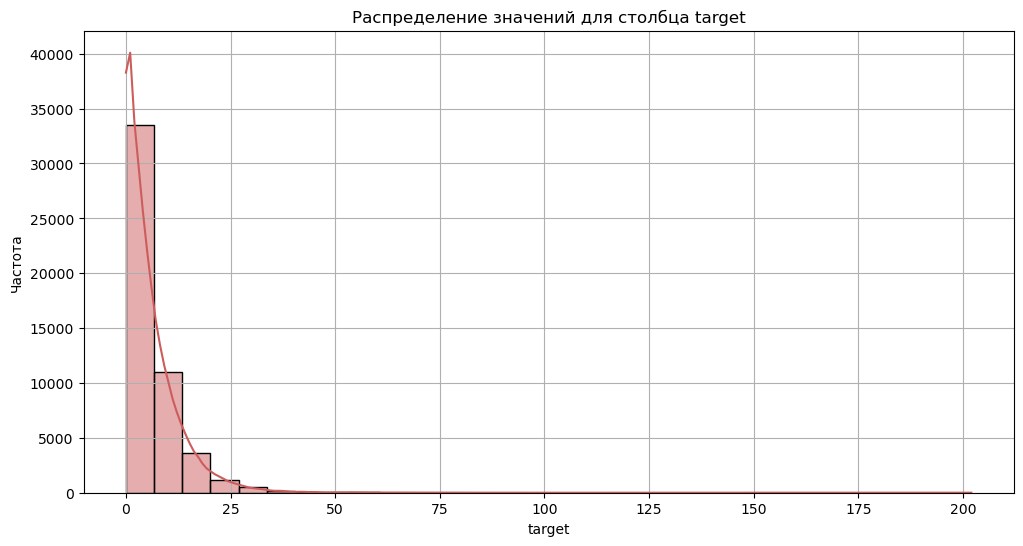

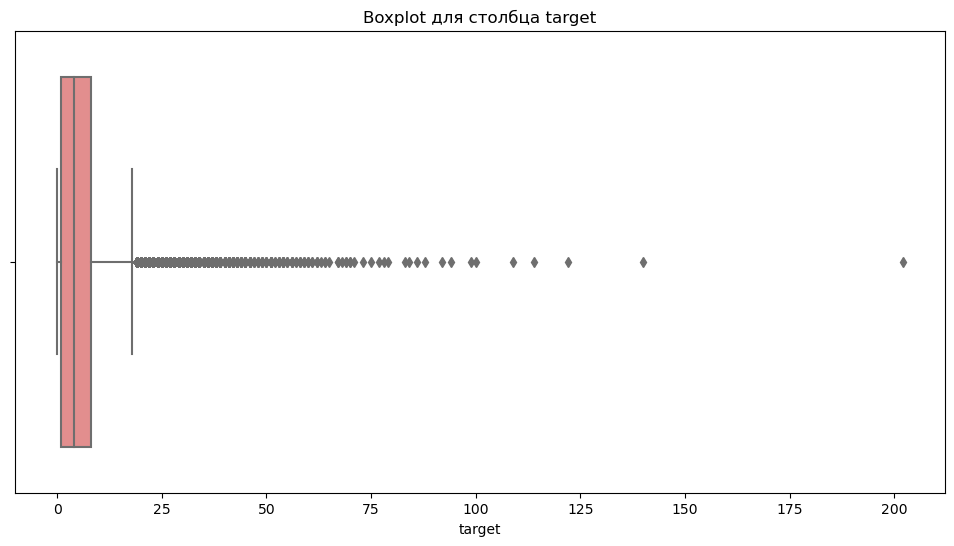

In [50]:
# Посмотрим уникальные значения и распределение их количества в наших датасетах
print('Тренировочный датасет')
plot_numerical_distribution_and_boxplot(df, 'target')

В этот раз строим только одну пару графиков, так как для тестового датасета предстоит только предсказать данные значения.

Вновь много аномальных значений, поэтому нужно будет готовиться к подобным ответам и в тестовой выборке. Большая часть значений вновь лежит в диапозоне до 20 дней.

### Корреляционный анализ
Проведём **корреляционный анализ** всех столбцов данных с целевым признаком - `target`.

У нас есть следующие категориальные признаки: 
- `insured_network`
- `nationality`
- `gender`
- `relation`
- `has_chronic_disease`
- `birth_month`

Есть ещё диагнозы, но их рассмотрим отдельно, так как слишком много категорий в наших выборках.

Для визуализации распределения воспользуемся треми видами графиков:
- `Boxplot`: для визуализации распределения целевого признака по категориям.
- `Violin Plot`: для отображения плотности распределения целевого признака в каждой категории.
- `Bar Plot` с добавлением доверительных интервалов: для отображения среднего значения целевого признака по категориям с уровнем значимости.

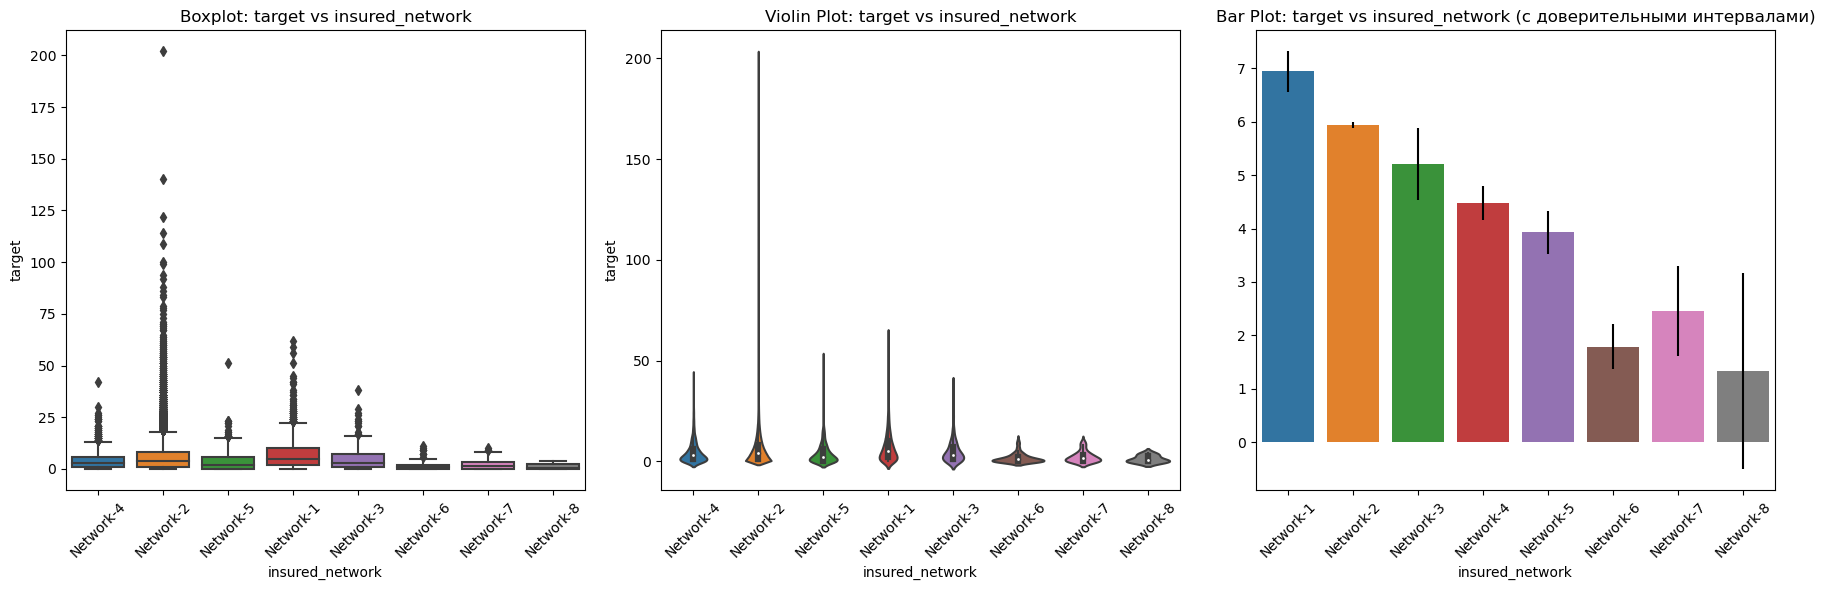

In [51]:
# Создаём списки названий категориальных и числовых признаков
categorical_features = get_categorical_features(df)
numeric_features = get_numerical_features(df, categorical_features)

# Построим графики распределения целевого признака в категориальных признаках (кроме Диагнозов)
# insured_pin    
plot_categorical_analysis(df, 'target', categorical_features[0])

Рассмотрим отдельно каждый из признаков последовательно.

**`insured_network`**

**Boxplot (слева)**:

* Этот график показывает распределение значений целевого признака (`target`) по категориям (`insured_network`).
* Видно, что `Network-4` и `Network-2` имеют много выбросов, особенно `Network-2`, где значения целевого признака могут достигать около 200.
* `Network-8` имеет самое низкое распределение значений target и почти не содержит выбросов.

**Violin Plot (в центре)**:

* Этот график показывает плотность распределения целевого признака по категориям.
* Плотности распределения для `Network-2` и `Network-4` показывают, что большинство значений сконцентрировано около низких значений, однако присутствуют длинные "хвосты" выбросов.
* `Network-8` имеет наименьшее распределение плотности, что подтверждает выводы из boxplot.

**Bar Plot (справа)**:

* Этот график показывает средние значения целевого признака по категориям с доверительными интервалами.
* `Network-1` имеет самое высокое среднее значение `target`, за ним следуют `Network-2` и `Network-4`.
* `Network-8` имеет самое низкое среднее значение целевого признака.
* Видно, что различия между средними значениями в разных сетях значительны, и доверительные интервалы помогают понять надежность этих оценок.

**Общие выводы:**
1. `Network-2` и `Network-4` содержат много выбросов и имеют высокие значения целевого признака, что может указывать на большую вариативность внутри этих категорий.
2. `Network-8` последовательно отображает самые низкие значения целевой переменной на всех графиках, что позволяет предположить, что она связана с более низкими целевыми значениями.
3. Средние значения целевого признака варьируются по сетям, и это может указывать на различия в характеристиках или политике этих сетей, которые влияют на целевой признак.
4. Доверительные интервалы в `bar plot` подтверждают, что различия между некоторыми сетями значимы, и это стоит учитывать при дальнейшем анализе или моделировании.

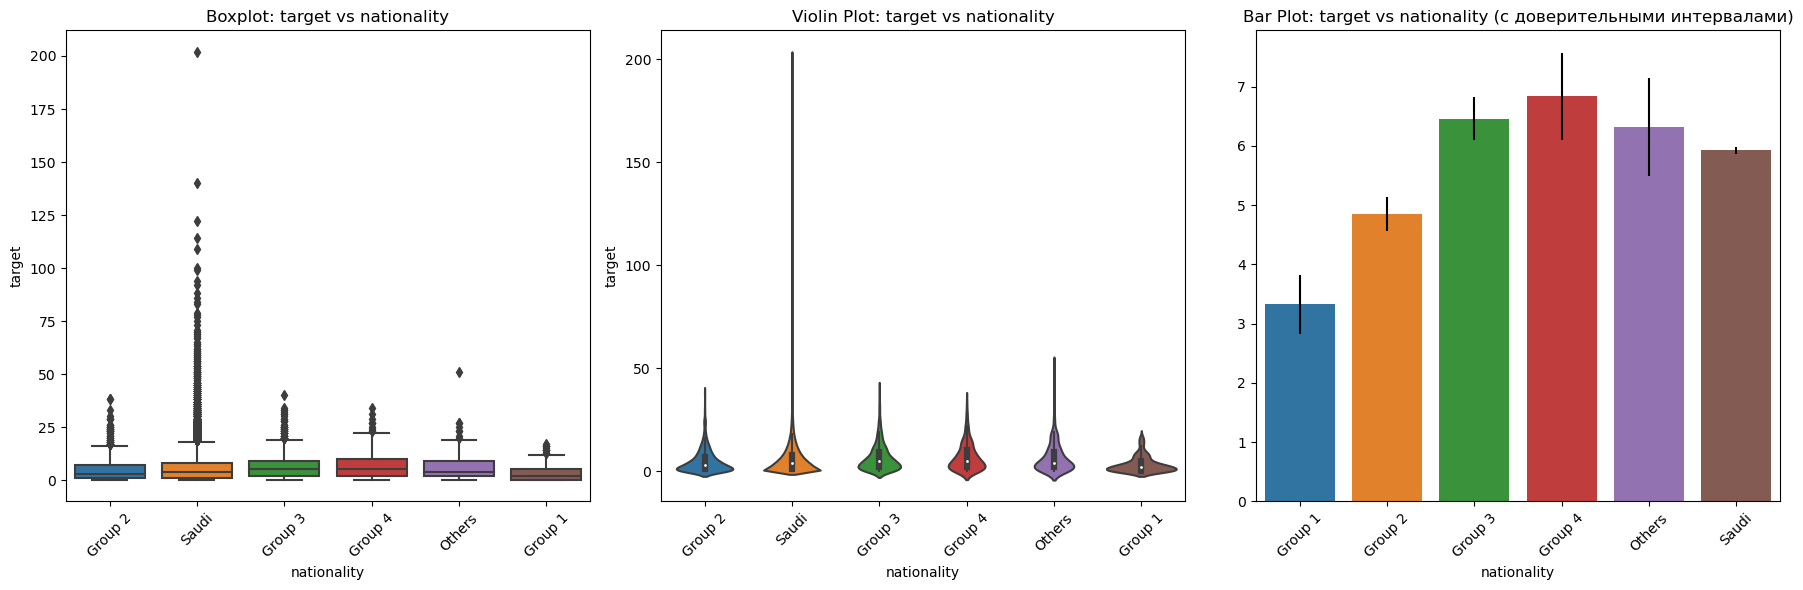

In [52]:
# nationality    
plot_categorical_analysis(df, 'target', categorical_features[1])

**`nationality`**

**Boxplot (слева)**:

* Этот график показывает распределение значений целевого признака (`target`) по категориям (`nationality`).
* `Saudi` имеет значительное количество выбросов и экстремально высокие значения, что значительно отличается от остальных групп.
* Другие группы, такие как `Group 1`, `Group 2`, `Group 3`, `Group 4`, и `Others`, имеют более низкие и менее разбросанные значения целевого признака.

**Violin Plot (в центре)**:

* Этот график показывает плотность распределения целевого признака по категориям.
* Плотность распределения для `Saudi` показывает длинный "хвост" выбросов, указывающий на значительное количество высоких значений.
* Другие группы имеют более компактное распределение с основной массой значений близкой к нулю и меньшим количеством выбросов.

**Bar Plot (справа)**:

* Этот график показывает средние значения целевого признака по категориям с доверительными интервалами.
* `Group 4` имеет самое высокое среднее значение целевого признака, за ним следуют `Group 3`, `Others`, и `Group 2`.
* `Saudi` имеет среднее значения ниже, чем `Group 3` и `Group 4`, несмотря на наличие большого количества выбросов.
* `Group 1` имеет самое низкое среднее значение целевого признака.
* Доверительные интервалы показывают значительную вариативность внутри групп, особенно для `Group 3`, `Group 4`, и `Others`.

**Общие выводы:**
1. `Saudi` показывает наибольшую вариативность и множество выбросов, что может указывать на специфические факторы, влияющие на целевой признак для этой национальности.
2. `Group 4` и `Group 3` имеют высокие средние значения целевого признака, что может указывать на большую значимость этих групп в контексте исследуемого признака.
3.  `Group 1` последовательно отображают самые низкие значения целевой переменной, указывая на различную модель поведения или особые характеристики для этой группы.
4. Доверительные интервалы показывают, что различия между некоторыми группами значимы, и это стоит учитывать при дальнейшем анализе или моделировании.

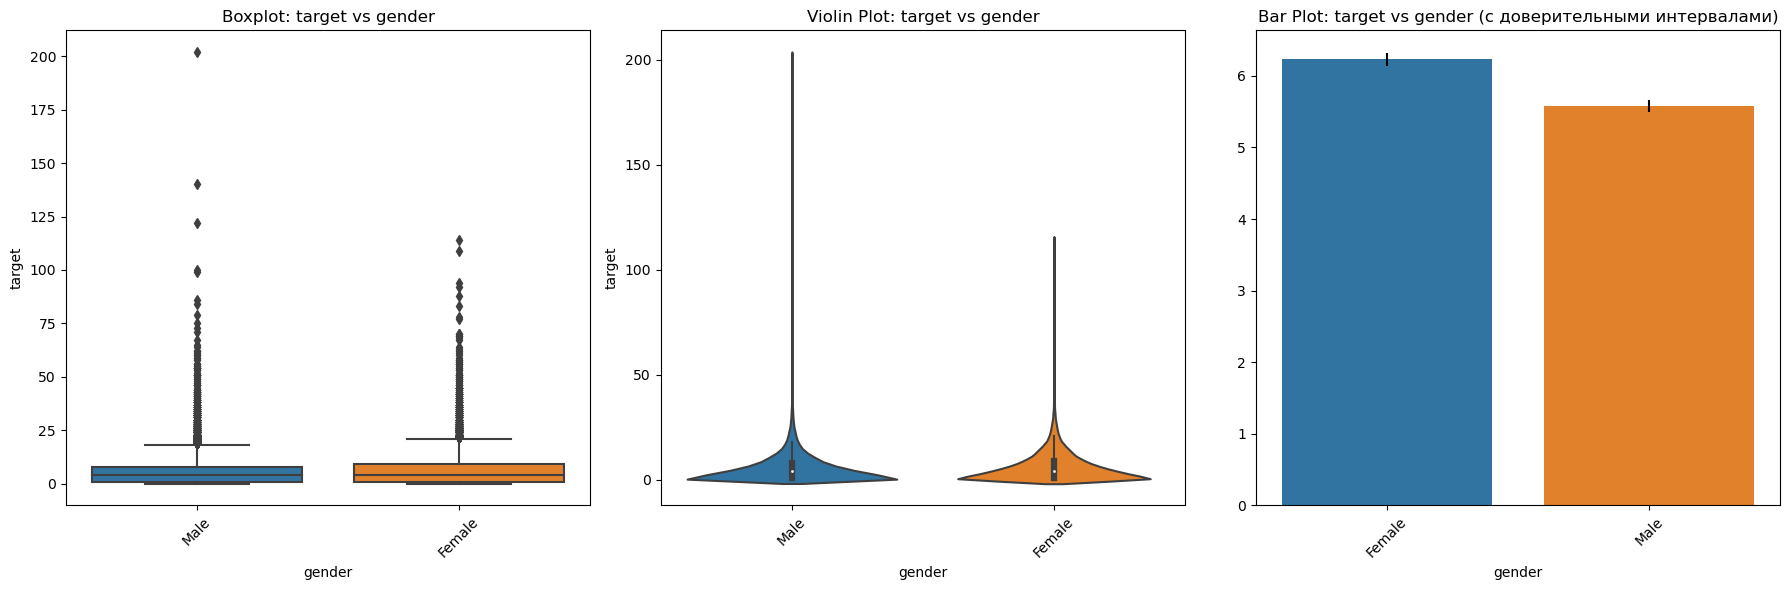

In [53]:
# gender   
plot_categorical_analysis(df, 'target', categorical_features[2])

**`gender`**

**Boxplot (слева)**:
* Этот график показывает распределение значений целевого признака (`target`) по категориям (`gender`).
* Для обеих категорий, `Male` и `Female`, распределение целевого признака имеет схожие характеристики, включая наличие выбросов и экстремально высокие значения.
* Средние значения целевого признака для обеих категорий близки друг к другу, что указывает на отсутствие значительных различий между полами.

**Violin Plot (в центре)**:
* Этот график показывает плотность распределения целевого признака по категориям.
* Плотность распределения для обеих категорий имеет схожую форму с длинными "хвостами" выбросов.
* Основная масса значений целевого признака сосредоточена ближе к нулю для обеих категорий, что не удивительно, так как в целом большое количество значений по целевому признаку менее 20.

**Bar Plot (справа)**:
* Этот график показывает средние значения целевого признака по категориям с доверительными интервалами.
* Среднее значение целевого признака для `Female` немного выше, чем для `Male`, что говорит нам о том, что женщины чуть чаще обращаются за медицинской помощью.
* Доверительные интервалы для обеих категорий пересекаются, что указывает на то, что различия между средними значениями могут быть незначительными и не статистически значимыми.

**Общие выводы:**
1. Распределение целевого признака для мужчин и женщин схоже, что указывает на отсутствие значительных различий в целевом признаке в зависимости от пола.
2. Средние значения целевого признака для женщин немного выше, но доверительные интервалы показывают, что эти различия могут быть незначительными.
3. Наличие выбросов и длинных "хвостов" для обеих категорий указывает на возможное влияние других факторов на целевой признак, которые не зависят от пола.

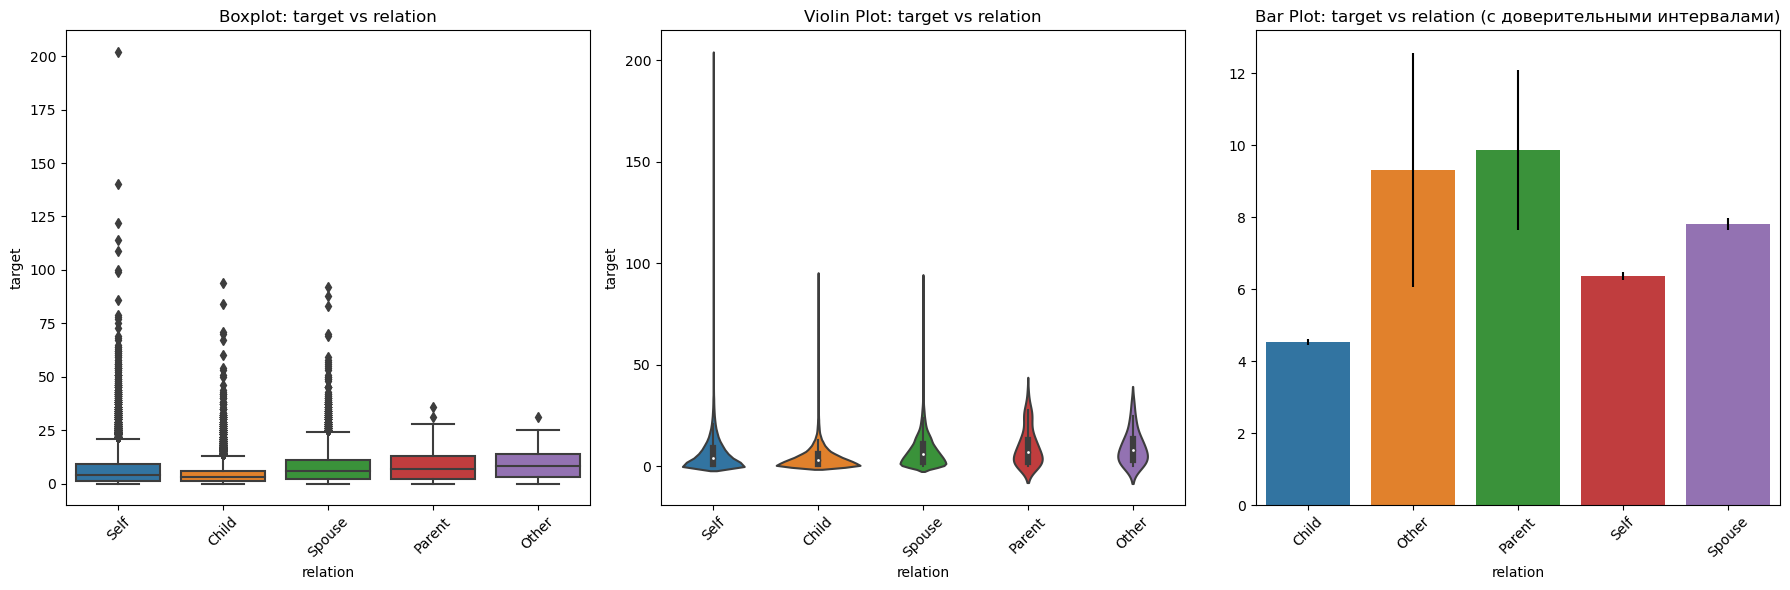

In [54]:
# relation   
plot_categorical_analysis(df, 'target', categorical_features[3])

**`relation`**

**Boxplot (слева)**:
* Этот график показывает распределение значений целевого признака (`target`) по категориям (`relation`).
*  Видно, что `Self`, `Child` и `Spouse` имеют много выбросов, особенно `Self`, где значения целевого признака могут достигать около 200. Рассматривая разом все графики, можно предположить, что выброс в районе 200 - это мужчина, национальности `Saudi`, который является работником компании.
* `Child` имеет самое маленькое значение, несмотря на большое количество выбросов.

**Violin Plot (в центре)**:
* Этот график показывает плотность распределения целевого признака по категориям.
* У признаков `Parent` и `Other` более вытянутая плотность распределение, несмотря на практическое отсутствие "хвостов".
* Плотность распределения для `Self` показывает длинный "хвост" выбросов, указывающий на значительное количество высоких значений.

**Bar Plot (справа)**:
* Этот график показывает средние значения целевого признака по категориям с доверительными интервалами.
* Самое высокое значение у `Parent`, после у `Other`, `Spouse`, `Self` и `Child`.
* Видно, что различия между средними значениями в разных сетях значительны, и доверительные интервалы помогают понять надежность этих оценок. 
* Доверительные интервалы показывают значительную вариативность внутри групп, особенно для `Other` и `Parent`.

**Общие выводы:**
1. `Self`, `Child`, и `Spouse` имеют большое количество выбросов, что указывает на высокую вариативность в этих категориях.
2. `Parent` и `Other` имеют более вытянутую плотность распределения, что указывает на более равномерное распределение значений 
3. Родители, как категория, в среднем чаще посещают клиники, а дети наоборот имеют более редкое посещение для получения медицинской помощи и/или возможно более крепкий иммунитет.
4. Высокие доверительные интервалы указывают на большую вариативность внутри категорий `Other` и `Parent`, что говорит о разнообразии значений внутри этих групп.

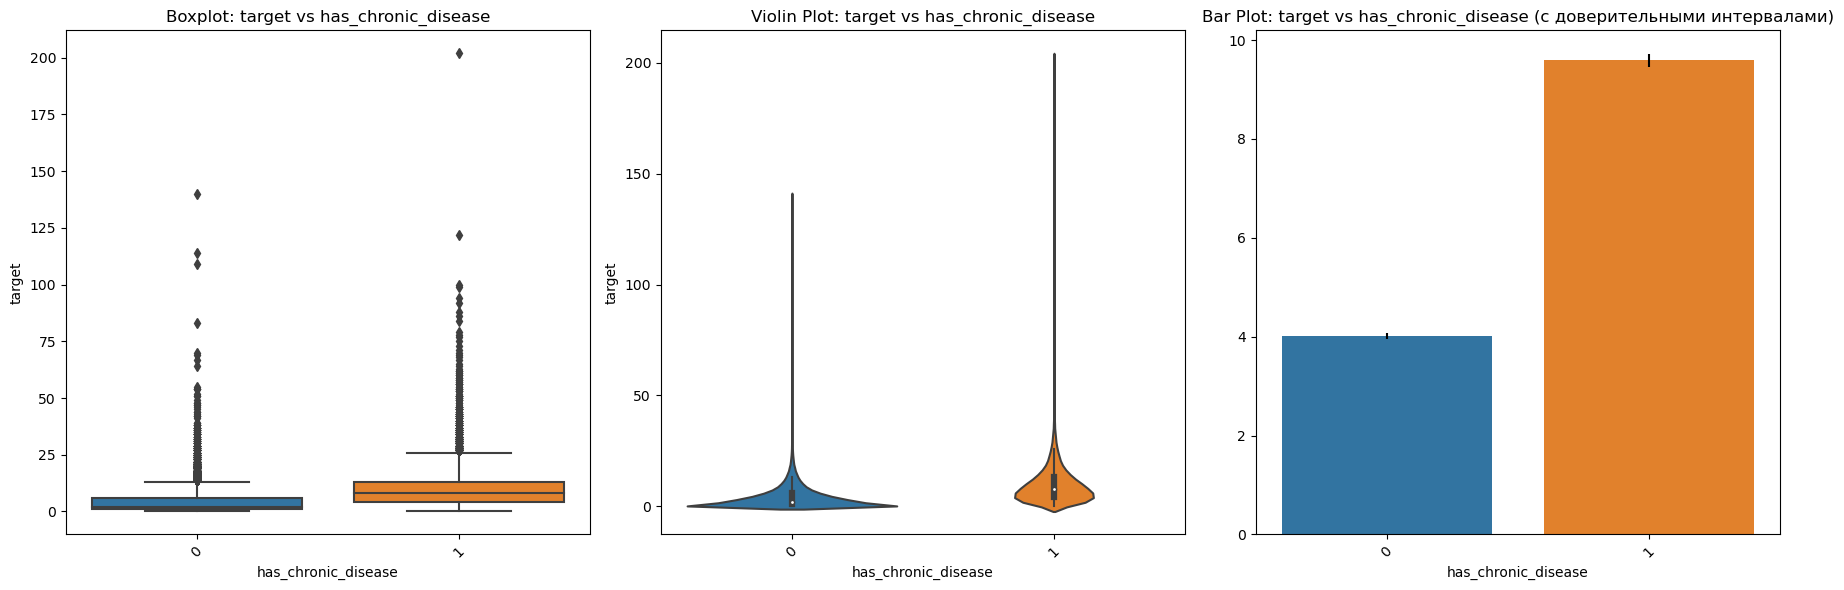

In [55]:
# has_chronic_disease 
plot_categorical_analysis(df, 'target', categorical_features[4])

**`has_chronic_disease`**

**Boxplot (слева)**:
* Этот график показывает распределение значений целевого признака (`target`) от наличия хронического заболевания (`has_chronic_disease`).
* 0 - отсутствие хронического заболевания, 1 - наличие хронического заболевания.
* Среднее значение `target` для обеих групп схоже, но в группе с хроническим заболеванием наблюдается больше выбросов, что указывает на большее количество высоких значений `target`.
* Межквартильный размах и медиана также почти одинаковы для обеих групп.

**Violin Plot (в центре)**:
* График также показывает распределение `target` в зависимости от `has_chronic_disease`, но в более детализированной форме.
* Видно, что основное распределение `target` для обеих групп сосредоточено около нуля.
* Группа с хроническим заболеванием имеет несколько больше высоких значений `target`, что соответствует наблюдаемым выбросам на boxplot.

**Bar Plot (справа)**:
* Этот график показывает средние значения целевого признака для каждой группы с доверительными интервалами.
* У людей с хроническим заболеванием среднее значение `target` заметно выше, чем у тех, у кого нет хронического заболевания.

**Общие выводы:**
1. Распределение значений `target`: Обе группы (с и без хронического заболевания) имеют схожие распределения значений `target`, с основным числом значений близких к нулю.
2. Высокие значения `target`: Группа с хроническим заболеванием имеет больше высоких значений `target`, что может указывать на то, что наличие хронического заболевания связано с повышенными обращением за медицинской помощью.
3. Средние значения `target`: Люди с хроническим заболеванием в среднем имеют более высокие значения `target`, что видно из bar plot.

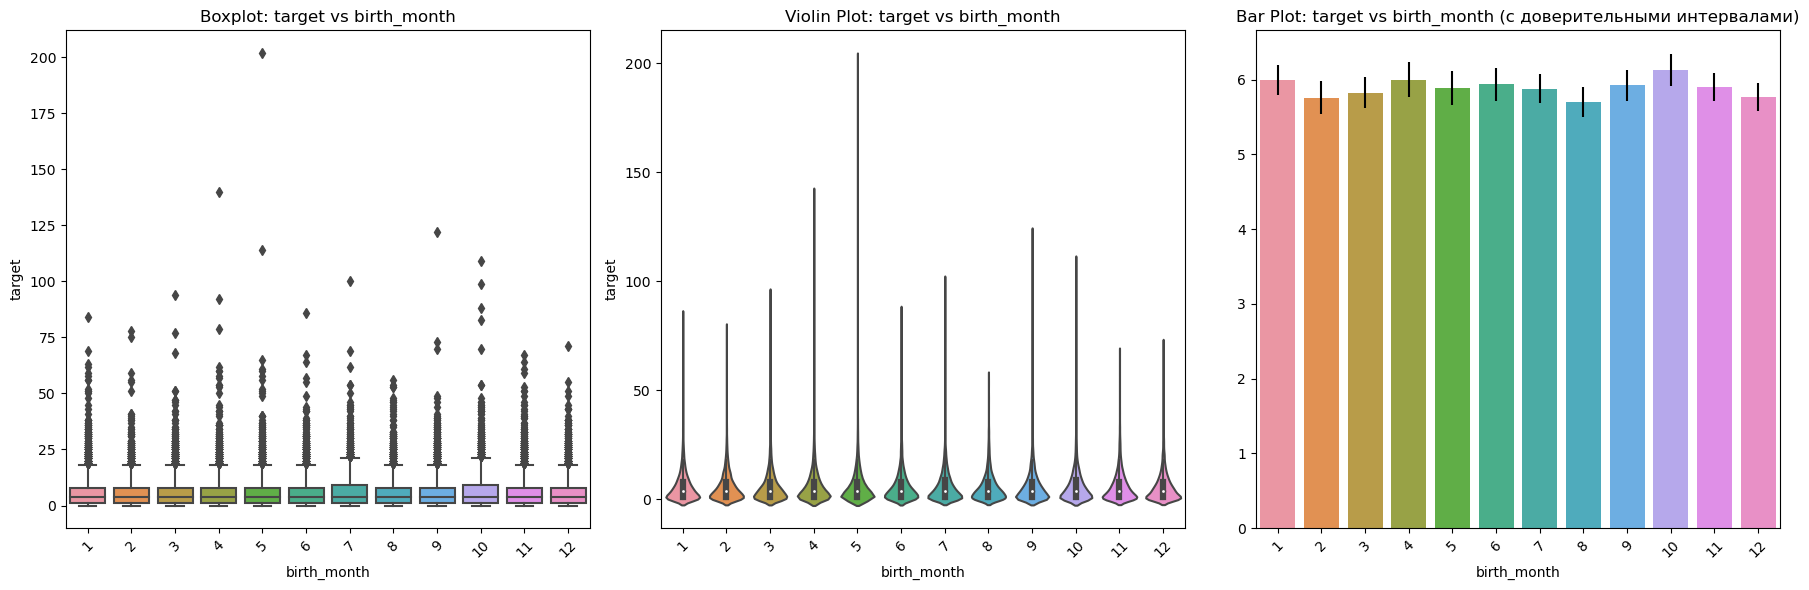

In [56]:
# birth_month 
plot_categorical_analysis(df, 'target', categorical_features[5])

**`birth_month`**

**Boxplot (слева)**:

* Каждый ящик показывает распределение целевой переменной в зависимости от месяца рождения.
* Видны выбросы в каждом месяце.
* Медиана не сильно различается между месяцами, но указывает на то, что распределение целевой переменной относительно равномерно.

**Violin Plot (в центре)**:

* Этот график комбинирует боксплот с распределением данных.
* Визуализирует плотность распределения целевой переменной для каждого месяца рождения.
* Плотность распределения целевой переменной схожа между месяцами, но можно заметить некоторое различие в форме распределений, что указывает на наличие особенностей в данных.

**Bar Plot (справа)**:

* Этот график показывает средние значения целевой переменной для каждого месяца рождения с доверительными интервалами.
* Видно, что средние значения целевой переменной несколько варьируются между месяцами, но в целом находятся в похожем диапазоне.


**Общие выводы:**
1) **Сезонные эффекты**: На всех трех графиках можно заметить, что целевая переменная имеет некоторое сезонное влияние, хотя и не очень сильное. Сезонные эффекты могут иметь некоторое влияние на целевую переменную.
2) **Выбросы**: Наличие множества выбросов в данных указывает на необходимость более детального анализа и, возможно, обработки выбросов.
3) **Средние значения**: Средние значения целевой переменной относительно стабильны между месяцами, но с небольшими вариациями. Это может означать, что месяц рождения оказывает ограниченное влияние на целевую переменную, но все же стоит учитывать этот фактор при моделировании.


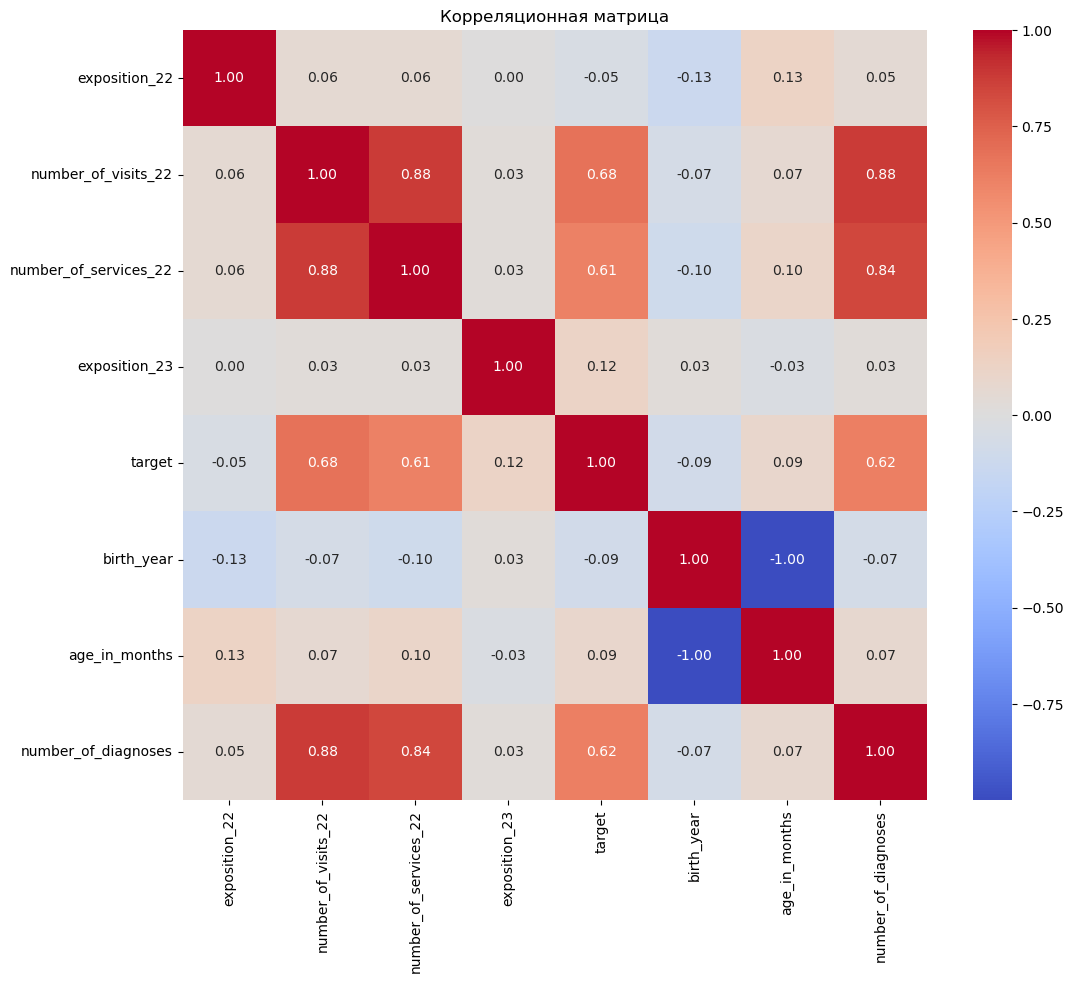

In [57]:
# Построение Корреляционной матрицы
plot_correlation_matrix(df, numeric_features)

**Сильные корреляции**
1. `number_of_visits_22` и `number_of_services_22` **(0.88)**:

Между количеством визитов в 2022 году и количеством услуг в 2022 году наблюдается сильная положительная корреляция. Это логично, так как большее количество визитов часто связано с большим количеством оказанных услуг.

    
2. `number_of_visits_22` и `number_of_diagnoses` **(0.88)**:

Также наблюдается сильная положительная корреляция между количеством визитов в 2022 году и количеством диагнозов. Больше визитов, вероятно, приводит к большему количеству диагностированных состояний.
    
3. `number_of_services_2`2 и `number_of_diagnoses` **(0.84)**:

Сильная положительная корреляция между количеством услуг и количеством диагнозов в 2022 году. Это тоже ожидаемо, так как большее количество диагностированных состояний требует больше услуг.

4. `target` и `number_of_visits_22` **(0.68)** и `number_of_services_22` **(0.61)**:

Значение целевой переменной сильно коррелирует с количеством визитов и количеством услуг в 2022 году. Это может указывать на то, что целевая переменная зависит от активности медицинских услуг.

5. `target` и `number_of_diagnoses` **(0.62)**:

Положительная корреляция между целевой переменной и количеством диагнозов. Это также указывает на то, что наличие большего количества диагнозов связано с увеличением целевой переменной.
    
    
**Умеренные и слабые корреляции**
1. `age_in_months` и `number_of_visits_22` **(0.13)**:

Умеренная положительная корреляция между возрастом в месяцах и количеством визитов в 2022 году. Возможно, старшие люди чаще посещают медицинские учреждения.

2. `age_in_months` и `number_of_services_22` **(0.10)**:

Умеренная положительная корреляция между возрастом в месяцах и количеством услуг в 2022 году. Старшие люди могут получать больше услуг.

3. `exposition_22` и `age_in_months` **(0.13)**:

Умеренная положительная корреляция между возрастом и `exposition_22`.
    
**Отрицательные корреляции**
1. `birth_year` и `age_in_months` **(-1.00)**:
Как и ожидается, существует сильная отрицательная корреляция между годом рождения и возрастом в месяцах, так как это прямые противоположности.

**Выводы**
1) Наиболее значимыми признаками для целевой переменной `target` являются количество визитов (`number_of_visits_22`), количество услуг (`number_of_services_22`) и количество диагнозов (`number_of_diagnoses`).
2) Взаимосвязь между возрастом и медицинскими услугами также присутствует, но она менее значительна по сравнению с вышеуказанными признаками.
3) Взаимосвязи между `exposition_22`, `exposition_23` и другими признаками не столь значимы.

In [58]:
# Посмотрим на данные ещё раз прежде, чем перейти к подготовке данных к обучению
data_review(df)

ПЕРВЫЕ 5 СТРОЧЕК С ДАННЫМИ:


,insured_pin,insured_network,nationality,gender,relation,do_b,diagnoses,has_chronic_disease,exposition_22,number_of_visits_22,number_of_services_22,exposition_23,target,birth_year,birth_month,age_in_months,number_of_diagnoses,has_duplicates
0,1006786,Network-4,Group 2,Male,Self,1974-04-28,no_diagnoses,0,365,0,0,365,0,1974,4,584,0,False
1,1008861,Network-2,Saudi,Female,Child,2017-07-27,J20.9;J02,0,365,1,2,365,4,2017,7,65,2,False
2,1019055,Network-5,Group 2,Male,Self,1979-02-20,J03.9,0,365,1,4,365,5,1979,2,526,1,False
3,1019438,Network-1,Saudi,Male,Self,1985-05-09,E56.9;J02;J00,1,365,3,18,365,11,1985,5,451,3,False
4,1027311,Network-3,Group 3,Male,Self,1962-01-01,no_diagnoses,0,365,0,0,365,0,1962,1,732,0,False



ОБЩАЯ ИНФОРМАЦИЯ О ДАННЫХ:

<class 'pandas.core.frame.DataFrame'>
Index: 49998 entries, 0 to 49999
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   insured_pin            49998 non-null  int64         
 1   insured_network        49998 non-null  object        
 2   nationality            49998 non-null  object        
 3   gender                 49998 non-null  object        
 4   relation               49998 non-null  object        
 5   do_b                   49998 non-null  datetime64[ns]
 6   diagnoses              49998 non-null  object        
 7   has_chronic_disease    49998 non-null  int64         
 8   exposition_22          49998 non-null  int64         
 9   number_of_visits_22    49998 non-null  int64         
 10  number_of_services_22  49998 non-null  int64         
 11  exposition_23          49998 non-null  int64         
 12  target                 49998 non-nul

,insured_pin,do_b,has_chronic_disease,exposition_22,number_of_visits_22,number_of_services_22,exposition_23,target,birth_year,birth_month,age_in_months,number_of_diagnoses
count,4.999800e+04,49998,49998.000000,49998.000000,49998.000000,49998.000000,49998.000000,49998.000000,49998.000000,49998.000000,49998.000000,49998.000000
mean,5.104225e+06,1990-02-22 22:04:42.539301632,0.337934,358.898716,5.740070,22.476239,355.588044,5.898496,1989.634345,6.671067,393.764851,5.661706
min,7.491000e+03,1920-03-21 00:00:00,0.000000,50.000000,0.000000,0.000000,50.000000,0.000000,1920.000000,1.000000,1.000000,0.000000
25%,1.394017e+06,1971-03-23 00:00:00,0.000000,365.000000,1.000000,3.000000,365.000000,1.000000,1971.000000,4.000000,140.000000,1.000000
50%,1.456638e+06,1991-11-14 00:00:00,0.000000,365.000000,4.000000,13.000000,365.000000,4.000000,1991.000000,7.000000,373.000000,4.000000
75%,1.560586e+06,2011-04-17 00:00:00,1.000000,365.000000,8.000000,31.000000,365.000000,8.000000,2011.000000,10.000000,621.000000,8.000000
max,9.100533e+07,2022-11-12 00:00:00,1.000000,365.000000,151.000000,962.000000,365.000000,202.000000,2022.000000,12.000000,1233.000000,69.000000
std,1.443775e+07,NaN,0.473010,35.562694,6.592542,29.714086,43.779900,6.856797,22.741925,3.508696,272.872471,6.156148


In [59]:
data_review(test)

ПЕРВЫЕ 5 СТРОЧЕК С ДАННЫМИ:


,insured_pin,insured_network,nationality,gender,relation,do_b,diagnoses,has_chronic_disease,exposition_22,number_of_visits_22,number_of_services_22,exposition_23,birth_year,birth_month,age_in_months,number_of_diagnoses,has_duplicates
0,1516424,Network-2,Saudi,Female,Child,2012-09-06,A09,0,365,1,3,365,2012,9,123,1,False
1,22210474,Network-1,Saudi,Female,Child,1995-10-26,T78.4;R50.9;Z01.8;R05,0,365,4,22,365,1995,10,326,4,False
2,1518945,Network-2,Saudi,Female,Spouse,1962-11-28,D64.9;J06;H04.1;M13.9,0,365,5,11,365,1962,11,721,4,False
3,1344077,Network-2,Saudi,Male,Child,2003-07-09,J06.9;J06.8;J02;G44.0;M25.5;R51;E55;L03,1,365,9,30,365,2003,7,233,8,False
4,1354276,Network-2,Saudi,Female,Spouse,1995-07-22,UNKRC;N64;A09,0,365,3,10,365,1995,7,329,3,False



ОБЩАЯ ИНФОРМАЦИЯ О ДАННЫХ:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   insured_pin            10000 non-null  int64         
 1   insured_network        10000 non-null  object        
 2   nationality            10000 non-null  object        
 3   gender                 10000 non-null  object        
 4   relation               10000 non-null  object        
 5   do_b                   10000 non-null  datetime64[ns]
 6   diagnoses              10000 non-null  object        
 7   has_chronic_disease    10000 non-null  int64         
 8   exposition_22          10000 non-null  int64         
 9   number_of_visits_22    10000 non-null  int64         
 10  number_of_services_22  10000 non-null  int64         
 11  exposition_23          10000 non-null  int64         
 12  birth_year             10000 non

,insured_pin,do_b,has_chronic_disease,exposition_22,number_of_visits_22,number_of_services_22,exposition_23,birth_year,birth_month,age_in_months,number_of_diagnoses
count,1.000000e+04,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5.321900e+06,1990-02-05 12:24:02.880000128,0.338000,359.426100,5.823600,22.991300,355.038600,1989.58540,6.693100,394.331800,5.695500
min,6.366500e+04,1922-02-13 00:00:00,0.000000,50.000000,0.000000,0.000000,50.000000,1922.00000,1.000000,1.000000,0.000000
25%,1.394638e+06,1970-09-01 18:00:00,0.000000,365.000000,1.000000,3.000000,365.000000,1970.00000,4.000000,142.000000,1.000000
50%,1.457448e+06,1991-11-09 12:00:00,0.000000,365.000000,4.000000,13.000000,365.000000,1991.00000,7.000000,373.000000,4.000000
75%,1.622645e+06,2011-02-19 06:00:00,1.000000,365.000000,8.000000,31.000000,365.000000,2011.00000,10.000000,627.250000,8.000000
max,9.105157e+07,2022-11-12 00:00:00,1.000000,365.000000,113.000000,495.000000,365.000000,2022.00000,12.000000,1210.000000,70.000000
std,1.487940e+07,NaN,0.473052,33.756826,6.789425,30.820412,45.307745,22.70475,3.541662,272.381924,6.240695


### Выводы:
1. Устранены пропуски в столбцах `do_b` и `diagnoses`.
2. Проверка на дубликаты показала, что каждый `insured_pin` уникален, что свидетельствует о корректной выгрузке данных.
3. Обнаружено большое количество выбросов; один из них был удалён из тренировочных данных.
4. Созданы новые признаки: год, месяц и возраст в месяцах рождения, количество диагнозов.
5. Составлен топ-10 диагнозов, которые могут быть дополнительно проанализированы и использованы для кодирования признаков в моделях.
6. Клиенты предпочитают клиники с высоким уровнем сервиса (`Network - 2`), тогда как клиники с базовым уровнем (6, 7 и 8) менее популярны.

Подробнее о пропусках и аномальных значениях можно узнать в разделах [Пропуски](#Пропуски) и [Аномальные значения](#Аномальные-значения).


**Краткие выводы из корреляционного анализа:**

1. **Сети (`Network`):**
   - `Network-2` и `Network-4` имеют высокие значения целевого признака и выбросы.
   - `Network-8` показывает низкие значения целевого признака.

2. **Национальность (`Nationality`):**
   - `Saudi` демонстрирует высокую вариативность и выбросы.
   - `Group 4` и `Group 3` имеют высокие средние значения целевого признака.

3. **Отношение (`Relation`):**
   - Категории `Self`, `Child`, и `Spouse` показывают много выбросов.
   - `Parent` и `Other` имеют более равномерное распределение.

4. Люди с хроническими заболеваниями чаще обращаются за медицинской помощью.
5. Наиболее значимые признаки для целевой переменной `target`: количество визитов (`number_of_visits_22`), количество услуг (`number_of_services_22`), количество диагнозов (`number_of_diagnoses`).
6. Взаимосвязь между возрастом и медицинскими услугами присутствует, но менее значительна.
7. Взаимосвязи между `exposition_22`, `exposition_23` и другими признаками незначительны.

**План:**

Подготовка данных к обучению (разбиение на выборки, масштабирование, кодирование), обучение моделей и выбор лучшей.

## Обучение

<a id="functions-learning"></a>
### Functions

In [60]:
def optimize_df(df):
    """Уменьшение размерности датафрейма"""
    initial_memory = df.memory_usage(deep=True).sum()
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type == 'float64' or col_type == 'float32':
            # Проверяем, можно ли привести float к int
            if df[col].apply(float.is_integer).all():
                df[col] = pd.to_numeric(df[col], downcast='integer')
            else:
                df[col] = pd.to_numeric(df[col], downcast='float')
        
        elif col_type == 'int64' or col_type == 'int32':
            df[col] = pd.to_numeric(df[col], downcast='integer')
        
        elif col_type == 'object':
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')
        
        elif col_type == 'bool':
            df[col] = df[col].astype('int8')
    
    final_memory = df.memory_usage(deep=True).sum()
    memory_reduction = (initial_memory - final_memory) / initial_memory * 100
    
    print(f"Память до оптимизации: {initial_memory} байт")
    print(f"Память после оптимизации: {final_memory} байт")
    print(f"Сокращение памяти: {memory_reduction:.2f}%")
    
    return df

In [61]:
# Обработка столбца diagnoses

# Извлечение топ-N диагнозов
def get_top_n_diagnoses(df, column, top_n=10):
    all_diagnoses = []
    for diagnoses in df[column]:
        if diagnoses != 'no_diagnoses':
            all_diagnoses.extend(diagnoses.split(';'))
    
    diagnosis_counts = Counter(all_diagnoses)
    top_diagnoses = [diagnosis for diagnosis, _ in diagnosis_counts.most_common(top_n)]
    
    return top_diagnoses

# Функция для преобразования столбца с диагнозами
def preprocess_diagnoses(df, column, top_diagnoses):
    df_processed = df.copy()
    
    # Создание бинарных признаков для топ-N диагнозов
    for diagnosis in top_diagnoses:
        df_processed[f'{column}_{diagnosis}'] = df[column].apply(lambda x: int(diagnosis in x.split(';')) if pd.notna(x) else 0)
    
    # Создание признака для отсутствующих диагнозов
    df_processed[f'{column}_no_diagnoses'] = df[column].apply(lambda x: int(x == 'no_diagnoses'))
    
    # Создание признака для других диагнозов
    df_processed[f'{column}_others'] = df[column].apply(lambda x: 
                                                        sum(diagnosis not in top_diagnoses 
                                                            for diagnosis in x.split(';')) 
                                                        if pd.notna(x) and x != 'no_diagnoses' else 0)
    
    # Удаление оригинального столбца
    df_processed.drop(columns=[column], inplace=True)
    
    return df_processed

### Подготовка к обучению

В блоке обучения мы будем обучать следующие модели регрессии:
- `CatBoost`
- `RandomForest`
- `GradientBoosting`
- `LinearRegression` и две её регуляризованные версии `Ridge` и `Lasso`.

Начнём обучение с `CatBoost`, так как эта самая неприхотливая модель среди представленных. Мы ей скормливаем обсолютно все признаки, но с небольшой предподготовкой (заполнение пропусков и удаление одного выброса, то что делали на предыдущих этапах).


С оставшимися моделями ситуация сложнее, так как они самостоятельно не умеют обрабатывать тестовые и категориальные признаки, чувствительны к разным масштабам (особенно Линейная регрессия) и тд. Поэтому для каждой модели будем подбирать гиперпараметры через `Optuna`, далее внутри кросс-валидации (чтобы не было утечки данных) будем масштабировать и кодировать признаки.

Единственное, отдельный план по кодированию приготовлен к столбцу `diagnoses`. Дело в том, что в тренировочном датасете уникальных значений в данном столбце в более 6 тысяч. Даже если бы мы обладали мощной оперативной памятью, `OneHotEncoder` добавил бы такое же количество столбцов, и это только по одному признаку. Что слишком много и тяжело для любой модели. Плюс, на предыдущих этапах был выявлен [Топ-10](#top10-diagnoses) по популярности среди диагнозов, которые были одинаковыми и у тренировочного, и у тестового датасета.

Понимаю, что это не самый лучший результат по обработке категориального признака, но диагнозов слишком много и этот топ мог бы меняться внутри каждого тренировочного батча, что тоже не очень хорошо, поэтому это единственный признак, который обрабатывается вне кросс-валидации. 

In [62]:
# Удалим сразу неинформативные признаки в обоих датасетах
list_drop_feat = ['insured_pin', 'do_b', 'has_duplicates']

# Идентификаторы застрахованных в тестовых наборах
ids = test['insured_pin']

df = df.drop(list_drop_feat, axis = 1)
test = test.drop(list_drop_feat, axis = 1)

##### CATBOOST

Так как `Catboost` может некорректно обработать данные в признаке `diagnoses`, то сделаем замену точек на нижнее подчёркивание, чтобы не спутал разделы МКБ с десятичными числами.

In [63]:
# Функция для замены точек на подчеркивания в диагнозах
replace_dots = lambda x: x.replace('.', '_') if isinstance(x, str) else x

# TRAIN
df_cat = df.copy()

# Заменяем точки на подчеркивания в диагнозах
df_cat['diagnoses'] = df_cat['diagnoses'].apply(replace_dots)


# TEST
test_cat = test.copy()

# Заменяем точки на подчеркивания в диагнозах
test_cat['diagnoses'] = test_cat['diagnoses'].apply(replace_dots)

In [64]:
# Уменьшаем размерность данных, чтобы ускорить процессы обучения и предсказания
df = optimize_df(df_cat)
print('')
test = optimize_df(test_cat)

Память до оптимизации: 20959652 байт
Память после оптимизации: 5820437 байт
Сокращение памяти: 72.23%

Память до оптимизации: 4033969 байт
Память после оптимизации: 1057371 байт
Сокращение памяти: 73.79%


In [65]:
# CATBOOST
# Разделим выборки на обучающую и тренировочную для каждой из групп моделей
X_cat = df_cat.drop('target', axis = 1)
y_cat = df_cat['target']
xtrain_cat, xtest_cat, ytrain_cat, ytest_cat = train_test_split(X_cat, y_cat, 
                                                                test_size=TEST_SIZE, 
                                                                shuffle=True, 
                                                                random_state=RANDOM_STATE)

# Подготовим сразу выборку для финального замера качества модели (если лучшей окажется CatBoost)
x_final_test_cat = test_cat

##### OTHERS models

In [66]:
# Определение моделей среди которых будем искать лучшую + CatBoost отдельно
model_names = [
    'RandomForestRegressor'
    , 'GradientBoostingRegressor'
     'Ridge'
    , 'Lasso'
    , 'LinearRegression'
]

In [67]:
# TRAIN
# Получение топ-N диагнозов
top_diagnoses = get_top_n_diagnoses(df, 'diagnoses', top_n=10)

# Преобразование столбца 'diagnoses'
df_processed = preprocess_diagnoses(df, 'diagnoses', top_diagnoses)

# Вывод преобразованных данных
df_processed.head()

,insured_network,nationality,gender,relation,has_chronic_disease,exposition_22,number_of_visits_22,number_of_services_22,exposition_23,target,...,diagnoses_J02,diagnoses_J20,diagnoses_J06,diagnoses_J03,diagnoses_E11,diagnoses_R10,diagnoses_J45,diagnoses_I10,diagnoses_no_diagnoses,diagnoses_others
0,Network-4,Group 2,Male,Self,0,365,0,0,365,0,...,0,0,0,0,0,0,0,0,1,0
1,Network-2,Saudi,Female,Child,0,365,1,2,365,4,...,1,0,0,0,0,0,0,0,0,1
2,Network-5,Group 2,Male,Self,0,365,1,4,365,5,...,0,0,0,0,0,0,0,0,0,1
3,Network-1,Saudi,Male,Self,1,365,3,18,365,11,...,1,0,0,0,0,0,0,0,0,1
4,Network-3,Group 3,Male,Self,0,365,0,0,365,0,...,0,0,0,0,0,0,0,0,1,0


In [68]:
# TEST

# Преобразование столбца 'diagnoses'
test_processed = preprocess_diagnoses(test, 'diagnoses', top_diagnoses)

# Вывод преобразованных данных
test_processed.head()

,insured_network,nationality,gender,relation,has_chronic_disease,exposition_22,number_of_visits_22,number_of_services_22,exposition_23,birth_year,...,diagnoses_J02,diagnoses_J20,diagnoses_J06,diagnoses_J03,diagnoses_E11,diagnoses_R10,diagnoses_J45,diagnoses_I10,diagnoses_no_diagnoses,diagnoses_others
0,Network-2,Saudi,Female,Child,0,365,1,3,365,2012,...,0,0,0,0,0,0,0,0,0,1
1,Network-1,Saudi,Female,Child,0,365,4,22,365,1995,...,0,0,0,0,0,0,0,0,0,4
2,Network-2,Saudi,Female,Spouse,0,365,5,11,365,1962,...,0,0,1,0,0,0,0,0,0,3
3,Network-2,Saudi,Male,Child,1,365,9,30,365,2003,...,1,0,0,0,0,0,0,0,0,6
4,Network-2,Saudi,Female,Spouse,0,365,3,10,365,1995,...,0,0,0,0,0,0,0,0,0,3


In [69]:
# Уменьшаем размерность данных, чтобы ускорить процессы обучения и предсказания
df = optimize_df(df_processed)
print('')
test = optimize_df(test_processed)

Память до оптимизации: 6251846 байт
Память после оптимизации: 2052014 байт
Сокращение памяти: 67.18%

Память до оптимизации: 1142228 байт
Память после оптимизации: 302228 байт
Сокращение памяти: 73.54%


In [70]:
# OTHERS models
X_others = df_processed.drop('target', axis = 1)
y_others = df_processed['target']

xtrain_others, xtest_others, ytrain_others, ytest_others = train_test_split(X_others, 
                                                                            y_others, 
                                                                            test_size=TEST_SIZE, 
                                                                            shuffle=True, 
                                                                            random_state=RANDOM_STATE)

# Подготовим сразу выборку для финального замера качества модели
x_final_test_others = test_processed

### TRAIN

#### CatBoostRegressor


Ранее столбец `diagnoses` отсутствовал в переменной `categorical_features`, так как он бы забрал несколько часов на корреляционном анализе из-за большого количества диагнозов внутри, а главное не дал бы важной информации всё равно.

Сейчас мы его добавляем, чтобы модель `CatBoost` корректнее обучалась.

In [71]:
# Добавление ещё одного названия категориального признака
categorical_features_cat = categorical_features.append('diagnoses')

# Сохраняем индексы категориальных признаков
categorical_features_indices = [X_cat.columns.get_loc(col) for col in categorical_features]

In [72]:
# Подбор гиперпараметров для CatBoostRegressor
def objective_catboost(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 100, 130, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.1),
        'depth': trial.suggest_int('depth', 10, 12, 2),
        'random_seed': RANDOM_STATE
    }
    model = CatBoostRegressor(**param, silent=True, cat_features=categorical_features_indices)
    train_pool = Pool(data=xtrain_cat, label=ytrain_cat, cat_features=categorical_features_indices)
    kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    
    score = cross_val_score(model, xtrain_cat, ytrain_cat, scoring=SCORE, cv=kf)
    return score.mean()

In [73]:
%%time
# Запуск оптимизации для CatBoostRegressor
study_catboost = optuna.create_study(direction='maximize')
study_catboost.optimize(objective_catboost, n_trials=N_TRIALS)
best_params_catboost = study_catboost.best_params

print(f"Best parameters for CatBoost: {best_params_catboost}")

Best parameters for CatBoost: {'iterations': 130, 'learning_rate': 0.09948113067721201, 'depth': 10}
CPU times: total: 1h 38min 34s
Wall time: 21min 4s


In [74]:
best_models_mse = {}
best_models_mse['CatBoostRegressor'] = CatBoostRegressor(**best_params_catboost, silent=True, cat_features=categorical_features_indices)
best_models_mse['CatBoostRegressor'].fit(xtrain_cat, ytrain_cat)

# Предсказания на тренировочных данных
predictions_train = best_models_mse['CatBoostRegressor'].predict(xtrain_cat)

# Вычисление MSE на тренировочных данных
mse_train = mean_squared_error(ytrain_cat, predictions_train)
print(f"Mean Squared Error on training data: {mse_train:.3f}")

Mean Squared Error on training data: 21.686


#### Others models

In [75]:
# Определение функций для Optuna
def objective_mse(trial, model_name, numeric_features, categorical_features):
    if model_name == 'RandomForestRegressor':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 60, 5),
            'max_depth': trial.suggest_int('max_depth', 5, 6),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 4)
        }
        model = RandomForestRegressor(random_state=RANDOM_STATE, **params)
        
    elif model_name == 'GradientBoostingRegressor':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 60, 5),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
            'max_depth': trial.suggest_int('max_depth', 5, 7, 2)
        }
        model = GradientBoostingRegressor(random_state=RANDOM_STATE, **params)
        
    elif model_name == 'Ridge':
        params = {
            'alpha': trial.suggest_float('alpha', 0.01, 10.0)
        }
        model = Ridge(random_state=RANDOM_STATE, **params)
        
    elif model_name == 'Lasso':
        params = {
            'alpha': trial.suggest_float('alpha', 0.01, 10.0)
        }
        model = Lasso(random_state=RANDOM_STATE, **params)
        
    else:
        model = LinearRegression()
        
    # Удаление признака target из числовых признаков
    numeric_features = [feature for feature in numeric_features if feature != 'target']
    
    # Создание трансформера для числовых и категориальных данных
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features[:-1])
        ])
    
    # Создание пайплайна
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Определение кросс-валидации с random_state
    kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    
    # Кросс-валидация
    cv_scores = cross_val_score(pipeline, xtrain_others, ytrain_others, cv=kf, scoring=SCORE)
    mse = -np.mean(cv_scores)
    return mse

In [76]:
%%time
# Оптимизация моделей
for model_name in model_names:
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective_mse(
        trial, model_name, numeric_features, categorical_features), n_trials=N_TRIALS)
    best_params = study.best_params if model_name != 'LinearRegression' else {}
    print(f"Best params for {model_name}: {best_params}")
    
    if model_name == 'RandomForestRegressor':
        best_model = RandomForestRegressor(random_state=RANDOM_STATE, **best_params)
    elif model_name == 'GradientBoostingRegressor':
        best_model = GradientBoostingRegressor(random_state=RANDOM_STATE, **best_params)
    elif model_name == 'Ridge':
        best_model = Ridge(random_state=RANDOM_STATE, **best_params)
    elif model_name == 'Lasso':
        best_model = Lasso(random_state=RANDOM_STATE, **best_params)
    else:
        best_model = LinearRegression()
    
    # Удаление признака target из числовых признаков
    numeric_features = [feature for feature in numeric_features if feature != 'target']
    
    # Создание трансформера для числовых и категориальных данных
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features[:-1])
        ])
    
    best_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', best_model)
    ])
    
    best_pipeline.fit(xtrain_others, ytrain_others)
    best_models_mse[model_name] = best_pipeline

Best params for RandomForestRegressor: {'n_estimators': 55, 'max_depth': 6, 'min_samples_split': 2}
Best params for GradientBoostingRegressorRidge: {}
Best params for Lasso: {'alpha': 0.014689732896620511}
Best params for LinearRegression: {}
CPU times: total: 20min 35s
Wall time: 3h 43min 50s


In [77]:
# Оценка и выбор лучшей модели на обучающих данных
best_model_name = None
best_cv_mse = float('inf')
for model_name, model in best_models_mse.items():
    cv_scores = cross_val_score(model, xtrain_others, ytrain_others, cv=5, scoring='neg_mean_squared_error')
    cv_mse = -np.mean(cv_scores)
    print(f"Cross-validated Mean Squared Error for {model_name}: {cv_mse:.4f}")
    if cv_mse < best_cv_mse:
        best_cv_mse = cv_mse
        best_model_name = model_name

print(f"\nBest model on training data: {best_model_name} with cross-validated MSE: {best_cv_mse:.4f}")

Cross-validated Mean Squared Error for CatBoostRegressor: 23.9261
Cross-validated Mean Squared Error for RandomForestRegressor: 24.3158
Cross-validated Mean Squared Error for GradientBoostingRegressorRidge: 24.5967
Cross-validated Mean Squared Error for Lasso: 24.5958
Cross-validated Mean Squared Error for LinearRegression: 24.5967

Best model on training data: CatBoostRegressor with cross-validated MSE: 23.9261


### TEST

In [78]:
# Тестирование лучшей модели на тестовых данных
if best_model_name == 'CatBoostRegressor':
    test_predictions = best_models_mse[best_model_name].predict(xtest_cat)
    mse_test = mean_squared_error(ytest_cat, test_predictions)
else:
    test_predictions = best_models_mse[best_model_name].predict(xtest_others)
    mse_test = mean_squared_error(ytest_others, test_predictions)

print(f"Mean Squared Error on test data for {best_model_name}: {mse_test:.4f}")

Mean Squared Error on test data for CatBoostRegressor: 22.8062


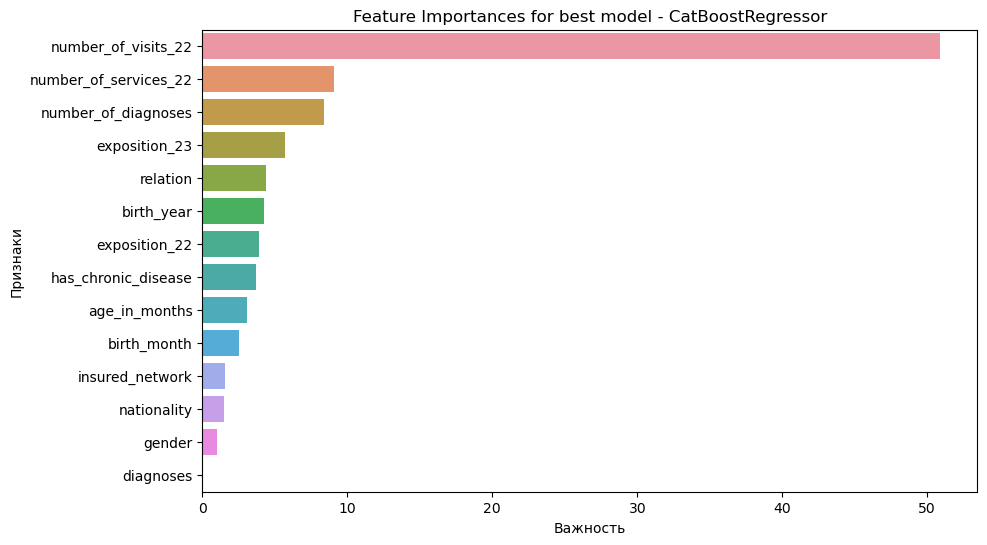

Feature importances saved to feature_importances_catboost.csv


In [79]:
# 1. График важности признаков
def plot_feature_importance(model, feature_names, model_name, output_file):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = model.coef_
    else:
        print("Model does not have feature_importances_ or coef_ attribute")
        return

    feature_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    
    # Построение графика
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importance, y=feature_importance.index)
    plt.title(f'Feature Importances for best model - {model_name}')
    plt.xlabel('Важность')
    plt.ylabel('Признаки')
    plt.show()
    
    # Сохранение данных в файл CSV
    feature_importance_df = feature_importance.reset_index()
    feature_importance_df.columns = ['Feature', 'Importance']
    feature_importance_df.to_csv(output_file, index=False)
    print(f"Feature importances saved to {output_file}")

# Проверка лучшей модели и вызов функции plot_feature_importance
if best_model_name == 'CatBoostRegressor':
    plot_feature_importance(best_models_mse[best_model_name], xtest_cat.columns, best_model_name, 'feature_importances_catboost.csv')
else:
    plot_feature_importance(best_models_mse[best_model_name].named_steps['model'], xtest_others.columns, best_model_name, 'feature_importances_best_model.csv')

По предоставленному графику "Feature Importances for best model - CatBoostRegressor" можно сделать следующие выводы:

1. **number_of_visits_22**:
   - Самый важный признак для предсказания количества посещений клиник в 2023 году. Это логично, так как количество посещений в предыдущем году является хорошим индикатором поведения застрахованного в следующем году.

2. **number_of_services_22**:
   - Второй по важности признак. Количество оказанных медицинских услуг также играет значительную роль в предсказании будущих посещений, так как это отражает степень использования медицинских услуг застрахованным.

3. **number_of_diagnoses**:
   - Количество диагнозов за 2022 год также является важным фактором. Это связано с тем, что большее количество диагнозов может указывать на более сложное состояние здоровья, требующее частых посещений клиник.

4. **exposition_23** и **exposition_22**:
   - Количество дней действия полиса в 2023 и 2022 годах соответственно. Важность этих признаков объясняется тем, что они отражают доступность медицинских услуг для застрахованного.

5. **birth_year**:
   - Год рождения застрахованного. Это может быть связано с возрастными особенностями потребления медицинских услуг.

6. **relation**:
   - Отношение застрахованного к основному страхователю (работник, ребенок, супруг и т.д.). Это может влиять на использование медицинских услуг.

7. **has_chronic_disease**:
   - Наличие хронического заболевания. Логично, что хронические пациенты чаще нуждаются в медицинской помощи.

8. **age_in_months**:
   - Возраст застрахованного в месяцах. Важный признак для детального анализа возрастных групп.

9. **birth_month**:
   - Месяц рождения застрахованного. Меньшая важность по сравнению с другими признаками, но все же может быть полезен для анализа сезонных факторов.

10. **insured_network**:
    - Уровень сети клиник, доступных для застрахованного. Отражает доступность и уровень сервиса медицинских услуг.

11. **nationality**:
    - Национальность застрахованного. Может иметь значение в контексте культурных особенностей потребления медицинских услуг.

12. **gender**:
    - Пол застрахованного. Меньшая важность, но может учитываться в модели для анализа различий в потреблении медицинских услуг между мужчинами и женщинами.

13. **diagnoses**:
    - Наличие конкретных диагнозов. Несмотря на низкую важность, все же учитывается в модели. Однако, скорее всего предстоит просто дополнительно исследовать данный признак, чтобы вытащить из него новые признаки, например.

В целом, модель CatBoostRegressor показала, что исторические данные о посещениях клиник и оказанных медицинских услугах являются ключевыми факторами для предсказания будущих посещений. Дополнительные признаки, такие как наличие хронических заболеваний и возраст, также играют значительную роль в модели.

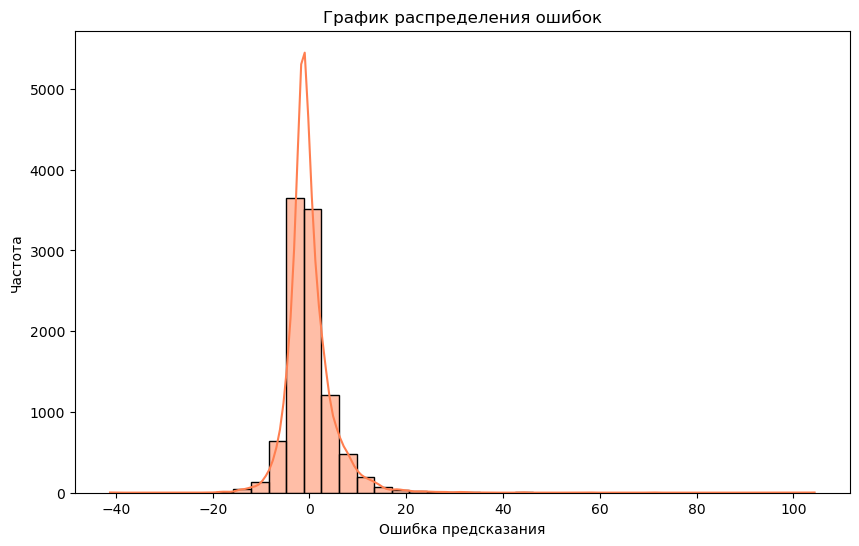

In [80]:
# 2. График распределения ошибок (разница между истиным и предсказанным значением)
errors = ytest_cat - test_predictions if best_model_name == 'CatBoostRegressor' else ytest_others - test_predictions

plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=40, kde=True, color='coral')
plt.title('График распределения ошибок')
plt.xlabel('Ошибка предсказания')
plt.ylabel('Частота')
plt.show()

На предоставленном графике можно сделать следующие выводы:

1. **Распределение ошибок**:
   - Основная масса ошибок сосредоточена около нуля, что указывает на то, что модель в большинстве случаев предсказывает довольно точно.
   - Распределение ошибок имеет вид нормального распределения с небольшим смещением вправо, что указывает на некоторое количество случаев, где модель недооценивает количество посещений (ошибка положительная).

2. **Хвосты распределения**:
   - Присутствуют длинные хвосты распределения, особенно справа. Это означает, что существуют некоторые наблюдения, где ошибки предсказаний значительно больше, что говорит о том, что модель в некоторых случаях существенно недооценивает значение целевой переменной.

3. **Общий уровень ошибок**:
   - Поскольку значение `Mean Squared Error` (MSE) составляет 22.7162, свидетельствующий о том, что в среднем квадратическая ошибка между предсказанными и фактическими значениями велика. Это означает, что модель плохо справляется с задачей предсказания числа посещений клиники.

4. **Заключение**:
   - В целом модель `CatBoostRegressor` показала слабые результаты с существенными ошибками предсказаний. Основные ошибки распределены около нуля, что является положительным признаком. Однако следует учитывать, что модель часто недооценивает количество посещений, что может требовать дополнительного анализа и, возможно, дальнейшей настройки модели для улучшения точности в этих случаях.

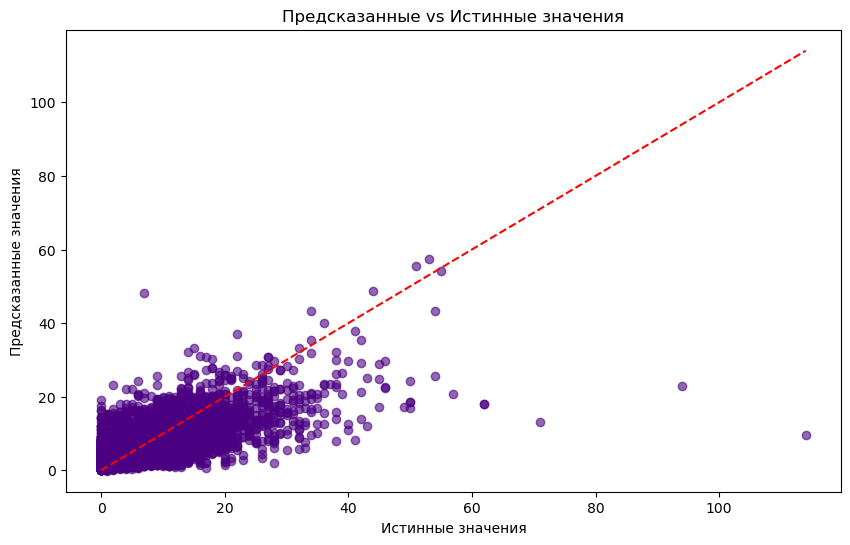

In [81]:
# 3. Дополнительный график: Предсказанные значения vs Истинные значения
plt.figure(figsize=(10, 6))
plt.scatter(ytest_cat if best_model_name == 'CatBoostRegressor' else ytest_others, test_predictions, alpha=0.6, color='indigo')
plt.plot([min(ytest_cat), max(ytest_cat)], [min(ytest_cat), max(ytest_cat)], color='red', linestyle='--')
plt.title('Предсказанные vs Истинные значения')
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.show()

На предоставленном графике можно сделать следующие выводы:

1. **Точность предсказаний**:
   - Видно, что большая часть точек располагается около линии y=x (красная пунктирная линия), что указывает на то, что модель в целом предсказывает значения, близкие к истинным.
   - Однако, имеется значительное количество точек, которые существенно отклоняются от этой линии, что указывает на высокие ошибки предсказаний в некоторых случаях.

2. **Недооценка и переоценка**:
   - Модель имеет тенденцию к недооценке высоких значений, что подтверждается точками, расположенными ниже линии y=x на правой стороне графика. Это соответствует предыдущим выводам о длинных правых хвостах распределения ошибок.
   - Также заметно, что модель переоценивает некоторые низкие значения, что приводит к точкам выше линии y=x на левой стороне графика.

3. **Общий уровень ошибок**:
   - Визуализация подтверждает высокое значение `Mean Squared Error` (MSE) 22.7162, указывая на значительные расхождения между предсказанными и истинными значениями.

4. **Заключение**:
   - Модель `CatBoostRegressor` демонстрирует смешанные результаты. Хотя она способна предсказывать близкие к истинным значениям для большинства случаев, имеются значительные ошибки, особенно для высоких значений целевой переменной. Это указывает на необходимость дальнейшей настройки модели и/или исследования дополнительных признаков для улучшения точности предсказаний.

Таким образом, текущая модель требует доработки, чтобы уменьшить значительные ошибки в предсказаниях и улучшить общую точность.

### Финальный замер качества
На выборке `holdout`.

In [82]:
# x_final_test_cat = x_final_test_cat.drop('insured_pin', axis=1)
# x_final_test_others = x_final_test_others.drop('insured_pin', axis=1)

# Если лучшая модель CatBoostRegressor
if best_model_name == 'CatBoostRegressor':
    model = CatBoostRegressor(**best_params_catboost, silent=True, cat_features=categorical_features_indices)
    model.fit(xtrain_cat, ytrain_cat)
    predictions = model.predict(x_final_test_cat)
    # Округление предсказаний до ближайшего целого числа
    predictions = np.round(predictions).astype(int)
    result_df = pd.DataFrame({'insured_pin': ids, 'prediction': predictions})

# Если лучшая модель не CatBoostRegressor
else:
    best_pipeline = best_models_mse[best_model_name]
    predictions = best_pipeline.predict(x_final_test_others)
    # Округление предсказаний до ближайшего целого числа
    predictions = np.round(predictions).astype(int)
    result_df = pd.DataFrame({'insured_pin': ids, 'prediction': predictions})

# Сохранение предсказаний в файл CSV
result_df.to_csv('predictions_holdout.csv', index=False)
print("Предсказания сохранены в файл 'predictions_holdout.csv'")

Предсказания сохранены в файл 'predictions_holdout.csv'


## Выводы

В рамках данного тестового задания были доступны данные о количестве обращений за медицинской помощью по 50 000 застрахованным ДМС за 2022 год. Требовалось на основании характеристик застрахованных и истории их обращений за 2022 год предсказать количество визитов за 2023 год на выборке `holdout`. 

Дано 2 выборки: 

- `train` - выборка для обучения и валидации, 50 тыс. застрахованных с проставленными значениями `target`.
- `holdout` - выборка для финального замера качества модели. В этой выборке 10 000 застрахованных, истинные значения `target` скрыты.

Для оценки качества модели применялась метрика `MSE`.

### Этапы проекта:
**1) [Загрузка необходимых библиотек и данных](#Загрузка-данных).**
- Данные загружены успешно, среди которых 12 столбцов с информацией застрахованного лица и 1 с данными, которые предстоит научиться предсказывать.

- Полных дубликатов не обнаружено, однако есть пропуски в данных, с которыми разбиралась на следующем этапе обработки данных. Радует, что они не в целевом признаке, поэтому большую часть данных осталась без удаления.

- Был составлен план на следующие этапы

**2) [Исследовательский анализ данных](#Исследовательский-анализ-данных),** 
который включал в себя предобработку данных (работа с пропусками, дубликатами, обработка текстовых данных и тд), создание новых признаков.

- Устранены пропуски в столбцах `do_b` и `diagnoses`.
- Проверка на дубликаты показала, что каждый `insured_pin` уникален, что свидетельствует о корректной выгрузке данных.
- Обнаружено большое количество выбросов; один из них был удалён из тренировочных данных.
- Созданы новые признаки: год, месяц и возраст в месяцах рождения, количество диагнозов.
- Составлен топ-10 диагнозов, которые могут быть дополнительно проанализированы и использованы для кодирования признаков в моделях.
- Клиенты предпочитают клиники с высоким уровнем сервиса (`Network - 2`), тогда как клиники с базовым уровнем (6, 7 и 8) менее популярны.


**Краткие выводы из [корреляционного анализа](#Корреляционный-анализ):**

1. **Сети (`Network`):**
   - `Network-2` и `Network-4` имеют высокие значения целевого признака и выбросы.
   - `Network-8` показывает низкие значения целевого признака.

2. **Национальность (`Nationality`):**
   - `Saudi` демонстрирует высокую вариативность и выбросы.
   - `Group 4` и `Group 3` имеют высокие средние значения целевого признака.

3. **Отношение (`Relation`):**
   - Категории `Self`, `Child`, и `Spouse` показывают много выбросов.
   - `Parent` и `Other` имеют более равномерное распределение.

4. Люди с хроническими заболеваниями чаще обращаются за медицинской помощью.
5. Наиболее значимые признаки для целевой переменной `target`: количество визитов (`number_of_visits_22`), количество услуг (`number_of_services_22`), количество диагнозов (`number_of_diagnoses`).
6. Взаимосвязь между возрастом и медицинскими услугами присутствует, но менее значительна.
7. Взаимосвязи между `exposition_22`, `exposition_23` и другими признаками незначительны.

**3) [Обучение нескольких моделей и выбор лучшей](#Обучение)**

Для обучения были выбраны:
- `CatBoostRegressor`
- `RandomForestRegressor`
- `GradientBoostingRegressor`
- `Ridge`
- `Lasso`
- `LinearRegression`

Для модели CatBoost были взяты все признаки с минимальной обработкой (предыдущие этапы), а для всех остальных был изменён признак `diagnoses` в 10-11 бинарных столбцов (топ-10 по частоте встречания диагнозы и отсутствие диагноза) и числовой признак `others`, в который записывалось количество оставшийся признаков. 
<img src="attachment:image.png" width="700"/>

А также внутри кросс-валидации произведено масштабирование и кодирование признаков. Подбор гиперпараметров осуществлялся `Optuna`.

Однако, результаты в целом у модели слабые, поэтому я бы сказала, что это скорее предварительный результат данной работы, так как такие результаты в прод 100% пускать нельзя...

Результаты обучения моделей и выбор лучшей:
<img src="attachment:image-3.png" width="600"/>

**4) [Тестирование лучшей модели](#TEST)**

Результат лучшей модели на тестовых данных:
<img src="attachment:image-5.png" width="500"/>

По графику ниже видно, что самые важные признаки для модели `CatBoostRegressor` – это исторические данные о количестве посещений клиник и оказанных медицинских услугах, а также количество диагнозов. Эти признаки являются ключевыми факторами для предсказания будущих посещений клиник.
<img src="attachment:image-6.png" width="800"/>


График распределения ошибок (ниже) показывает, что большинство ошибок модели CatBoostRegressor сосредоточены около нуля, что является положительным моментом. Однако наличие значительного числа ошибок за пределами этого диапазона, а также высокая метрика `MSE` (22.7162), указывает на то, что модель недостаточно хорошо справляется с предсказанием количества посещений клиник, и ее точность оставляет желать лучшего.
<img src="attachment:image-7.png" width="800"/>


**5) Выводы**

 Спасибо, что дочитали до этого момента:) 

Работа была произведена большая, хотя всё равно многое надо бы ещё сделать, чтобы улучшить метрику. Начиная от более тщательного подбора гиперпараметров (маленьй диапозон перебирался в силу экономии времени) до более детальной работы с признаком `diagnoses`, который показал около нулевую значимость для лучшей модели. От создания ещё новых признаков до асамблеевых моделей (и возможно, даже нейросетки для текстового столбца `diagnoses`). Возможно, через некоторое время я найду в себе силы, и доведу до какого-то красивого результата, но а пока рассматриваем только имеющиеся результаты.

Метрика низкая, особенно, если учитывать, что большая часть целевого признака находится в диапозоне до 20, а `mse` = 22, это средняя ошибка в районе 4,7 дней. То есть 20% разбег относительно самих данных, что безусло очень много. Судя по данным, которые на руках, модель не переобучается, так как разница в метриках между тренировочной и тестовой незначительная (стабильно плохо:D).

Лучшая модель демонстрирует смешанные результаты. Хотя она способна предсказывать близкие к истинным значениям для большинства случаев, имеются значительные ошибки, особенно для высоких значений целевой переменной. Это указывает на **необходимость дальнейшей настройки модели и/или исследования дополнительных признаков для улучшения точности предсказаний.**

И последние уточнения:
- **Файл .csv с предсказаниями на выборке** `holdout` с указанием ид застрахованного и предсказанием модели - находится в папке с данным ноутбуком. Сохрание в файл было [тут](#Финальный-замер-качества).
- **Список использованных признаков** с указанием их значимости - аналогично находится в папке с данным ноутбуком, а сохрание было [тут](#TEST).

***Если честно, буду очень рада обратной связи, идеям, как можно улучшить метрику, результату на финальном замере и тд.***

***Поэтому надеюсь, что до скорых встреч!***